In [1]:
!pip install --upgrade pip
!pip install torch torchvision scipy tdqm matplotlib scipy transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

# Google Drive Mount

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Import Modules

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

from scipy.linalg import sqrtm
import numpy as np
import os

from tqdm import tqdm
from matplotlib import pyplot as plt

In [4]:
def image_normalize(image):
    image = image.cpu()
    n_channels = image.shape[0]
    for channel in range(n_channels):
        max_value = torch.max(image[channel])
        min_value = torch.min(image[channel])
        image[channel] = (image[channel] - min_value) / (max_value - min_value)

    image = image.permute(1, 2, 0)

    return image

def print_image(image):
    image = image_normalize(image)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

def print_2images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_normalize(image1))
    axes[0].set_title('Image 1')

    axes[1].imshow(image_normalize(image2))
    axes[1].set_title('Image 2')

    plt.tight_layout()
    plt.show()

def print_result(result):
    for image, noised_image, denoised_image in result:
        batch_size = image.shape[0]
        for idx in range(batch_size):
            print_2images(image[idx], denoised_image[idx])
            # print_image(image[idx])
            # print_image(noised_image[idx])
            # print_image(denoised_image[idx])


def print_loss(loss_values):
    epochs = list(range(1, len(loss_values) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_values, 'b-o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NoiseSchedule
- betas, alphas

In [6]:
class NoiseSchedule:

    def __init__(self, n_timesteps, beta_start=0.0001, beta_end=0.02, device=device, init_type='linear') -> None:
        self._size = n_timesteps
        if init_type == 'linear':
            self._betas = torch.linspace(beta_start, beta_end, n_timesteps).to(device)
        if init_type == 'exponential':
            self._betas = torch.from_numpy(np.geomspace(beta_start, beta_end, n_timesteps)).to(device)
        self._alphas = self._calculate_alphas()

        # print(self._betas)
        # print(self._alphas)

    def _calculate_alphas(self):
        self._alphas = torch.cumprod(1 - self._betas, axis=0)
        return self._alphas

    def get_beta(self, index):
        if index >= self._size:
            raise IndexError("[get] out of index :", index, " / size :", self._size)
        return self._betas[index]

    def get_alpha(self, index):
        if index >= self._size:
            raise IndexError("[get] out of index :", index, " / size :", self._size)
        return self._alphas[index]

# ForwardEncoder

In [7]:
class ForwardEncoder:

    def __init__(self, noise_schedule) -> None:
        self.noise_schedule = noise_schedule

    def noise(self, data, time_step):
        # time_step : [B]
        # data : [B, 1, 32, 32]

        alpha = self.noise_schedule._alphas[time_step]
        alpha = alpha.reshape(-1, 1, 1, 1)
        # alpha : [B, 1, 1, 1]

        epsilon = torch.randn(data.shape).to(device)
        # torch.randn ~ N(0, 1)

        return torch.sqrt(alpha) * data + torch.sqrt(1 - alpha) * epsilon, epsilon

# ReverseDecoder

In [8]:
import torch

class ReverseDecoder:

    def __init__(self, noise_schedule, g) -> None:
        self.noise_schedule = noise_schedule
        self.g = g

    def denoise(self, noise_data, time_step, c=None, w=0):
        # noise_data : [B, 1, 32, 32]
        # c : [B]
        # time_step : INT

        batch_size = noise_data.shape[0]
        # batch_size : B

        with torch.no_grad():

            # step : [T - 1, T - 2, .. 2, 1, 0]
            for step in range(time_step - 1, -1, -1):

                t = torch.full((batch_size, ), step).to(device)
                t = t.reshape(-1, 1, 1, 1)
                # t : [B, 1, 1, 1]

                predict_noise = (1 + w) * self.g(noise_data, t, c) - w * self.g(noise_data, t)
                mu = 1 / torch.sqrt(1 - self.noise_schedule._betas[t]) * (noise_data - (self.noise_schedule._betas[t] / (1 - self.noise_schedule._alphas[t])) * predict_noise)
                # mu : [B, 1, 32, 32]

                if step == 0:
                    # if t == 0, no add noise
                    break

                epsilon = torch.randn(noise_data.shape).to(device)
                # epsilon : [B, 1, 32, 32]

                noise_data = mu + torch.sqrt(self.noise_schedule._betas[t]) * epsilon
                # noise_data : [B, 1, 32, 32]

        return noise_data

    def implicit_denoise(self, noise_data, time_step, c=None, w=0, sampling_time_step=10):
        # noise_data : [B, 1, 32, 32]
        # c : [B]
        # time_step : INT

        batch_size = noise_data.shape[0]
        tau = list(range(0, time_step, time_step // sampling_time_step))
        S = len(tau)
        # print(tau)

        # batch_size : B
        with torch.no_grad():

            # step : [T - 1, T - 2, .. 2, 1, 0]
            for i in range(S - 1, -1, -1):

                t = torch.full((batch_size, ), tau[i]).to(device)
                t = t.reshape(-1, 1, 1, 1)
                alpha_t = self.noise_schedule._alphas[t]

                alpha_t_1 = torch.full((batch_size, 1, 1, 1,), 1).to(device)
                if i - 1 >= 0:
                    t_1 = torch.full((batch_size, ), tau[i - 1]).to(device)
                    t_1 = t_1.reshape(-1, 1, 1, 1)
                    alpha_t_1 = self.noise_schedule._alphas[t_1]

                predict_noise = (1 + w) * self.g(noise_data, t, c) - w * self.g(noise_data, t)
                first = torch.sqrt(alpha_t_1) * ((noise_data - torch.sqrt(1 - alpha_t) * predict_noise) / torch.sqrt(alpha_t))
                second = torch.sqrt(1 - alpha_t_1) * predict_noise

                noise_data = first + second

        return noise_data

# UNet

In [9]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding


class UNetConv2D(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=3, kernel_size=3, stride=1, padding=1):
        super(UNetConv2D, self).__init__()
        self.n = n
        self.ks = kernel_size
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.SiLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, s, p),
                                     nn.SiLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv=True, is_batchnorm=True):
        super(UNetUp, self).__init__()
        # self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
        self.conv = UNetConv2D(out_size*2, out_size, is_batchnorm)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs0, *input):
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)

        return self.conv(outputs0)


class UNetTimeEmbedding(nn.Module):

    def __init__(self, dim_in, dim_out) -> None:
        super(UNetTimeEmbedding, self).__init__()
        self.ln = nn.Linear(dim_in, dim_out)
        self.activation = nn.SiLU()
        self.ln2 = nn.Linear(dim_out, dim_out)


    def forward(self, inputs):
        B = inputs.shape[0]

        x = self.ln(inputs)
        x = self.activation(x)
        x = self.ln2(x)

        return x.reshape(B, -1, 1, 1)


class UNet(nn.Module):

    def __init__(
        self,
        in_channels = 1,
        out_channels = 1,
        n_steps = 1000,
        time_emb_dim = 256,
        n_classes = 10,
        class_emb_dim = 64,
        channel_scale = 64,
        feature_scale = 5,
        is_deconv = True,
        is_batchnorm = True
    ):
        super(UNet, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        # time embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # conditional variable embedding
        self.class_embed = nn.Embedding(n_classes, class_emb_dim)
        self.class_embed.weight.data = sinusoidal_embedding(n_classes, class_emb_dim)
        self.class_embed.requires_grad_(False)

        # filters = [64, 128, 256, 512, 1024]
        filters = [channel_scale * i for i in range(1, 1 + feature_scale)]
        # filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = UNetConv2D(self.in_channels, filters[0], self.is_batchnorm)
        self.temb1 = UNetTimeEmbedding(time_emb_dim, filters[0])
        self.cemb1 = UNetTimeEmbedding(class_emb_dim, filters[0])
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = UNetConv2D(filters[0], filters[1], self.is_batchnorm)
        self.temb2 = UNetTimeEmbedding(time_emb_dim, filters[1])
        self.cemb2 = UNetTimeEmbedding(class_emb_dim, filters[1])
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = UNetConv2D(filters[1], filters[2], self.is_batchnorm)
        self.temb3 = UNetTimeEmbedding(time_emb_dim, filters[2])
        self.cemb3 = UNetTimeEmbedding(class_emb_dim, filters[2])
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = UNetConv2D(filters[2], filters[3], self.is_batchnorm)
        self.temb4 = UNetTimeEmbedding(time_emb_dim, filters[3])
        self.cemb4 = UNetTimeEmbedding(class_emb_dim, filters[3])
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = UNetConv2D(filters[3], filters[4], self.is_batchnorm)
        self.temb_center = UNetTimeEmbedding(time_emb_dim, filters[4])
        self.cemb_center = UNetTimeEmbedding(class_emb_dim, filters[4])

        # upsampling
        self.up_concat4 = UNetUp(filters[4], filters[3], self.is_deconv, self.is_batchnorm)
        self.up_temb4 = UNetTimeEmbedding(time_emb_dim, filters[3])
        self.up_cemb4 = UNetTimeEmbedding(class_emb_dim, filters[3])

        self.up_concat3 = UNetUp(filters[3], filters[2], self.is_deconv, self.is_batchnorm)
        self.up_temb3 = UNetTimeEmbedding(time_emb_dim, filters[2])
        self.up_cemb3 = UNetTimeEmbedding(class_emb_dim, filters[2])

        self.up_concat2 = UNetUp(filters[2], filters[1], self.is_deconv, self.is_batchnorm)
        self.up_temb2 = UNetTimeEmbedding(time_emb_dim, filters[1])
        self.up_cemb2 = UNetTimeEmbedding(class_emb_dim, filters[1])

        self.up_concat1 = UNetUp(filters[1], filters[0], self.is_deconv, self.is_batchnorm)
        self.up_temb1 = UNetTimeEmbedding(time_emb_dim, filters[0])
        self.up_cemb1 = UNetTimeEmbedding(class_emb_dim, filters[0])

        # output
        self.outconv1 = nn.Conv2d(filters[0], self.out_channels, 3, padding=1)


    def forward(self, inputs, t, c=None):
        t = self.time_embed(t)
        if c is not None:
            c = self.class_embed(c)
        # inputs : [B, 1, 32, 32]

        conv1 = self.conv1(inputs)  # [B, 64, 32, 32]
        emb1 = self.temb1(t) + self.cemb1(c) if c is not None else 0
        maxpool1 = self.maxpool1(conv1 + emb1)  # [B, 64, 16, 16]

        conv2 = self.conv2(maxpool1)  # [B, 128, 16, 16]
        emb2 = self.temb2(t) + self.cemb2(c) if c is not None else 0
        maxpool2 = self.maxpool2(conv2 + emb2)  # [B, 128, 8, 8]

        conv3 = self.conv3(maxpool2)  # [B, 256, 8, 8]
        emb3 = self.temb3(t) + self.cemb3(c) if c is not None else 0
        maxpool3 = self.maxpool3(conv3 + emb3)  # [B, 256, 4, 4]

        conv4 = self.conv4(maxpool3)  # [B, 512, 4, 4]
        emb4 = self.temb4(t) + self.cemb4(c) if c is not None else 0
        maxpool4 = self.maxpool4(conv4 + emb4)  # [B, 512, 2, 2]

        emb_center = self.temb_center(t) + self.cemb_center(c) if c is not None else 0
        center = self.center(maxpool4) + emb_center # [B, 1024, 2, 2]


        up_emb4 = self.up_temb4(t) + self.up_cemb4(c) if c is not None else 0
        up4 = self.up_concat4(center, conv4) + up_emb4  # [B, 512, 4, 4]

        up_emb3 = self.up_temb3(t) + self.up_cemb3(c) if c is not None else 0
        up3 = self.up_concat3(up4, conv3) + up_emb3 # [B, 256, 8, 8]

        up_emb2 = self.up_temb2(t) + self.up_cemb2(c) if c is not None else 0
        up2 = self.up_concat2(up3, conv2) + up_emb2 # [B, 128, 16, 16]

        up_emb1 = self.up_temb1(t) + self.up_cemb1(c) if c is not None else 0
        up1 = self.up_concat1(up2, conv1) + up_emb1 # [B, 64, 32, 32]

        out = self.outconv1(up1)  # [B, 1, 32, 32]

        return out

# DDPM

In [10]:
class DDPM:

    def __init__(
        self,
        n_timesteps,
        train_set=None,
        test_set=None,
        in_channels=1,
        out_channels=1,
        channel_scale=64,
        train_batch_size=8,
        test_batch_size=8
    ):

        self.n_timesteps = n_timesteps
        self.channel_scale = channel_scale

        # UNet for predicting total noise
        self.g = UNet(in_channels=in_channels,
                      out_channels=out_channels,
                      n_steps=n_timesteps,
                      channel_scale=channel_scale)
        self.g = self.g.to(device)

        # alpha, betas
        self.noise_schedule = NoiseSchedule(n_timesteps=n_timesteps)

        # forward encoder
        self.encoder = ForwardEncoder(noise_schedule=self.noise_schedule)
        self.decoder = ReverseDecoder(noise_schedule=self.noise_schedule, g=self.g)

        # optimizer
        self.lossFunction = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.g.parameters(), lr=0.0001)

        # datasets
        if train_set:
            self.training_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
        if test_set:
            self.testing_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=True)


    def save(self, path='./model.pt'):
        torch.save(self.g.state_dict(), path)


    def load(self, path='./model.pt'):
        self.g.load_state_dict(torch.load(path))
        self.g.eval()


    def train_one_epoch(
        self,
        n_iter_limit = None,
        p_uncond = 0.1
    ):

        running_loss = 0

        for i, data in enumerate(tqdm(self.training_loader)):

            # inputs = [B, 1, 32, 32]
            inputs, label = data
            inputs = inputs.to(device)
            # print(inputs.shape)

            batch_size = inputs.shape[0]

            # sampled timestep and conditional variables
            t = torch.randint(0, self.n_timesteps, (batch_size, )).to(device)
            c = label.to(device)

            # outputs = [B, 1, 28, 28]
            noised_image, epsilon = self.encoder.noise(inputs, t)

            outputs = None
            if torch.rand((1, )).item() < p_uncond:
                outputs = self.g(noised_image, t)
            else:
                outputs = self.g(noised_image, t, c)

            loss = self.lossFunction(outputs, epsilon)

            # Adjust learning weights
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

            if i == n_iter_limit:
                break

        return running_loss / len(self.training_loader)


    def train(
        self,
        n_epoch=5,
        n_iter_limit=None,
        p_uncond=0.1
    ):

        history = []

        for epoch in range(n_epoch):
            print('EPOCH {}:'.format(epoch + 1))

            # Make sure gradient tracking is on, and do a pass over the data
            self.g.train(True)
            avg_loss = self.train_one_epoch(n_iter_limit=n_iter_limit,
                                            p_uncond=p_uncond)
            history.append(avg_loss)
            print('# epoch {} avg_loss: {}'.format(epoch + 1, avg_loss))

            model_path = 'U{}_T{}_E{}.pt'.format(self.channel_scale,
                                                             self.n_timesteps,
                                                             epoch + 1)
            torch.save(self.g.state_dict(), model_path)
            torch.save(torch.tensor(history), 'history.pt')

        return history


    def evaluate(
        self,
        epochs = None,
        sampling_type = 'DDPM',
        sampling_time_step = 10,
        w = 0
    ):
        self.decoder.g = self.g
        result = []
        for i, data in enumerate(tqdm(self.testing_loader)):

            # inputs = [B, 1, 32, 32]
            inputs, label = data # data['image']
            inputs = inputs.to(device)

            batch_size = inputs.shape[0]

            # timestep
            t = torch.full((batch_size, ), self.n_timesteps - 1).to(device)
            c = label.to(device)

            # outputs = [B, 1, 28, 28]
            noised_image, epsilon = self.encoder.noise(inputs, t)

            # denoised image
            denoised_image = None
            if sampling_type == 'DDPM':
                denoised_image = self.decoder.denoise(noised_image,
                                                      self.n_timesteps,
                                                      c=c,
                                                      w=w)
            if sampling_type == 'DDIM':
                denoised_image = self.decoder.implicit_denoise(
                    noised_image,
                    self.n_timesteps,
                    c=c,
                    w=w,
                    sampling_time_step=sampling_time_step
                )

            result.append((inputs, noised_image, denoised_image))

            if i == epochs - 1:
                break

        return result

# Train

In [11]:
TIME_STEPS = 1000
BATCH_SIZE = 384

noise_schedule = NoiseSchedule(n_timesteps=TIME_STEPS, init_type='exponential')

In [12]:
# dataset = load_dataset("junyeong-nero/mnist_32by32").with_format("torch")
# train, test = dataset['train'], dataset['test']

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST(root='./data', train=True, download=True, transform=transform)
test = MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14617727.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482266.48it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3773216.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8558189.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
model = DDPM(
    n_timesteps=TIME_STEPS,
    in_channels=1,
    out_channels=1,
    channel_scale=256,
    train_set=train,
    test_set=test,
    train_batch_size=BATCH_SIZE,
    test_batch_size=8
)

In [14]:
print("model size : ", sum(p.numel() for p in model.g.parameters() if p.requires_grad))

model size :  214475009


In [ ]:
history = model.train(
    n_epoch=30,
    p_uncond=0.1
)

EPOCH 1:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 1 avg_loss: 0.07800178481325222
EPOCH 2:


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


# epoch 2 avg_loss: 0.03592259118891066
EPOCH 3:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 3 avg_loss: 0.029423237784178394
EPOCH 4:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 4 avg_loss: 0.026800064429356035
EPOCH 5:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 5 avg_loss: 0.025283394132260304
EPOCH 6:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 6 avg_loss: 0.02354248289232421
EPOCH 7:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 7 avg_loss: 0.02291599651620646
EPOCH 8:


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


# epoch 8 avg_loss: 0.022672131028809366
EPOCH 9:


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


# epoch 9 avg_loss: 0.021608594888050087
EPOCH 10:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 10 avg_loss: 0.02158189908998787
EPOCH 11:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 11 avg_loss: 0.0206995180624116
EPOCH 12:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 12 avg_loss: 0.020063875017652087
EPOCH 13:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 13 avg_loss: 0.019870733124482783
EPOCH 14:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 14 avg_loss: 0.022463324046723403
EPOCH 15:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 15 avg_loss: 0.021484827183803935
EPOCH 16:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 16 avg_loss: 0.019654902694806173
EPOCH 17:


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


# epoch 17 avg_loss: 0.01950679580639502
EPOCH 18:


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


# epoch 18 avg_loss: 0.019169082888846944
EPOCH 19:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 19 avg_loss: 0.01888081611721379
EPOCH 20:


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


# epoch 20 avg_loss: 0.01845692756591709
EPOCH 21:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 21 avg_loss: 0.018372384505049816
EPOCH 22:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 22 avg_loss: 0.018072923236069786
EPOCH 23:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 23 avg_loss: 0.017666218837924824
EPOCH 24:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 24 avg_loss: 0.01753293816000223
EPOCH 25:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 25 avg_loss: 0.018748896439696194
EPOCH 26:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 26 avg_loss: 0.01836729794740677
EPOCH 27:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 27 avg_loss: 0.01753692670019379
EPOCH 28:


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


# epoch 28 avg_loss: 0.0172884001034745
EPOCH 29:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 29 avg_loss: 0.017761882827587568
EPOCH 30:


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


# epoch 30 avg_loss: 0.017255286680190426


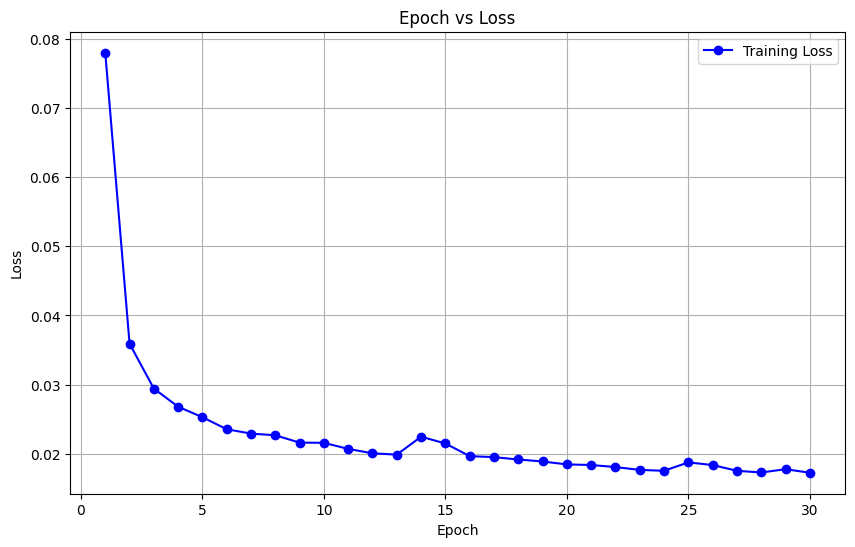

In [ ]:
print_loss(history)

In [34]:
MODEL_PATH = '/content/drive/My Drive/models/DDPM_MNIST/U256_T1000_E29_P02.pt'
# MODEL_PATH = './U256_T1000_E30.pt'
model.load(MODEL_PATH)

# Sampling: DDPM

In [ ]:
result_DDPM = model.evaluate(
    epochs=5,
    w=0
)

  0%|          | 2/1250 [00:45<7:56:00, 22.89s/it]

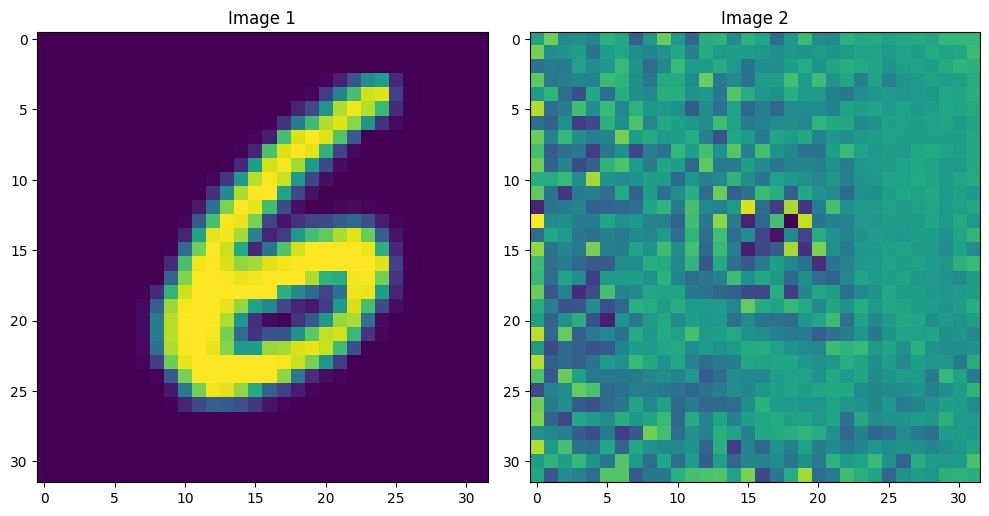

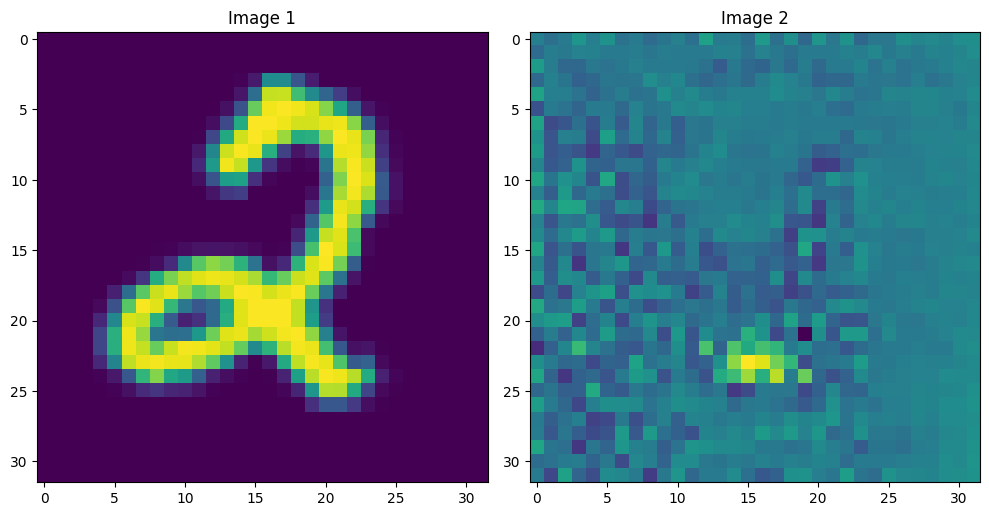

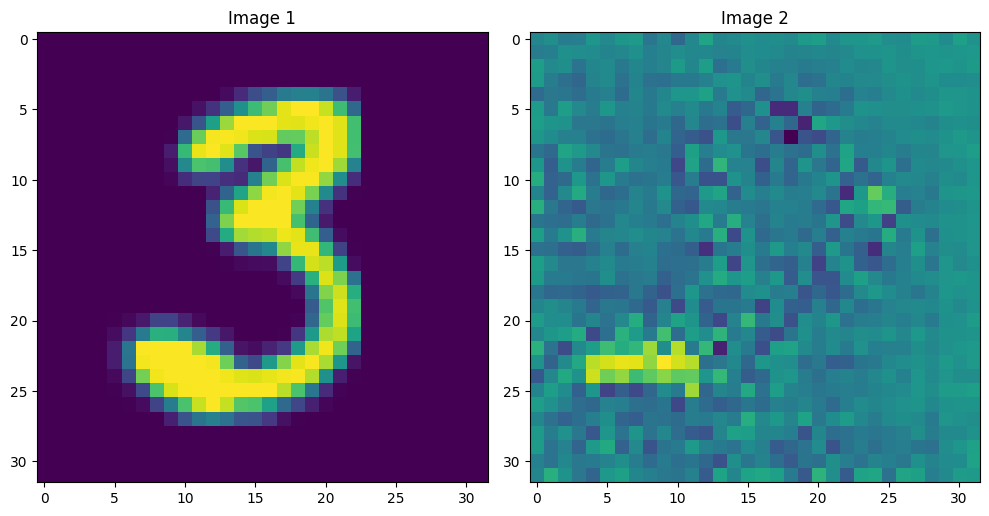

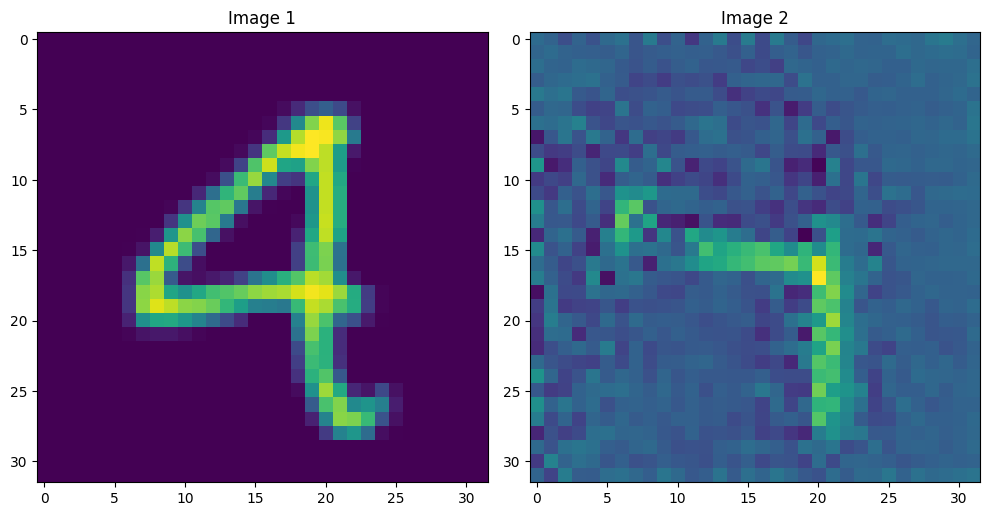

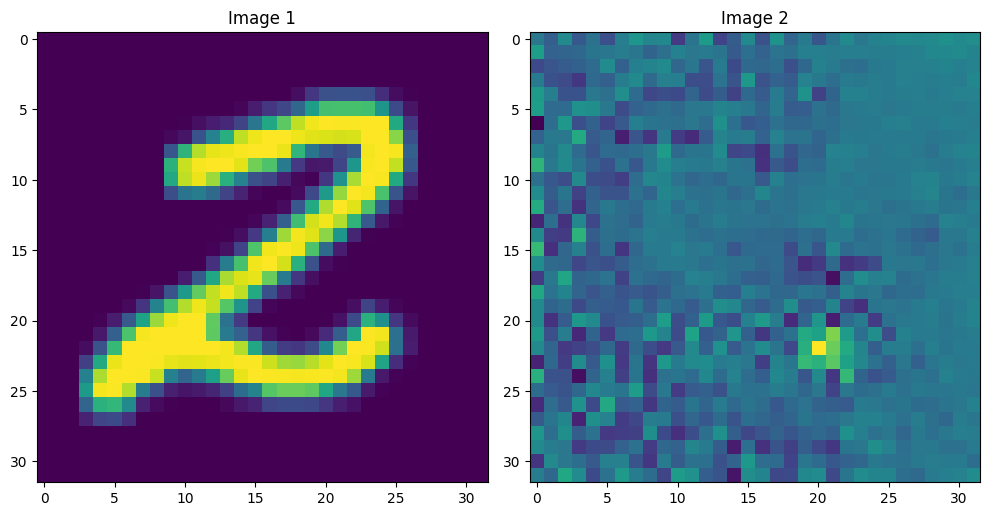

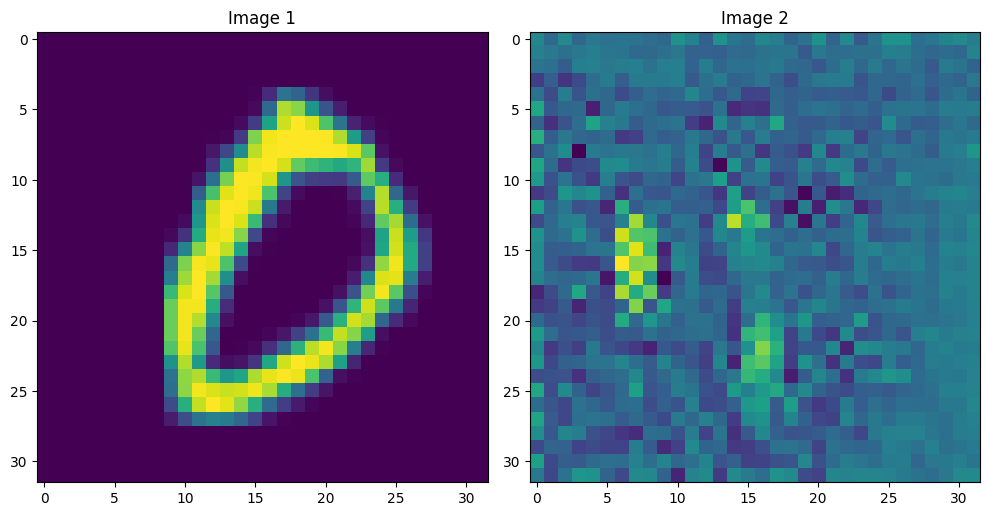

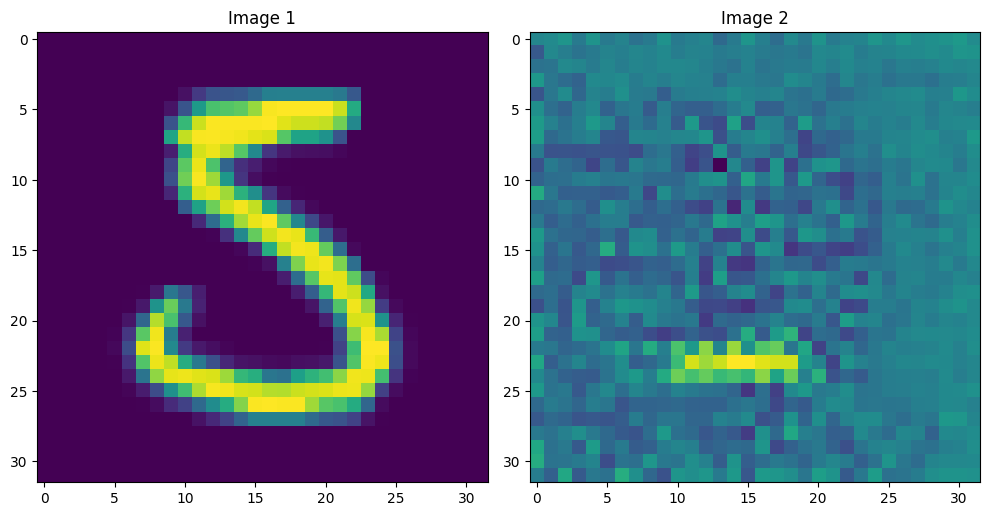

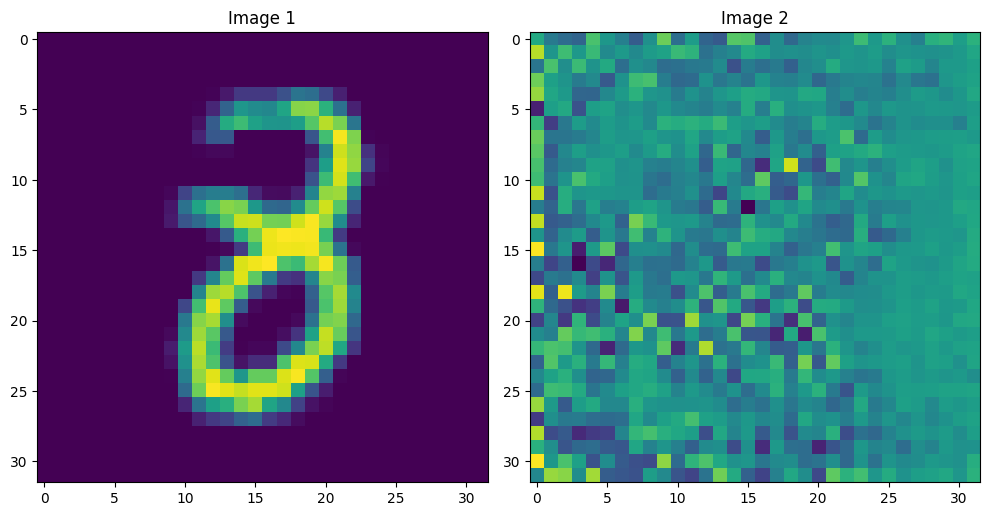

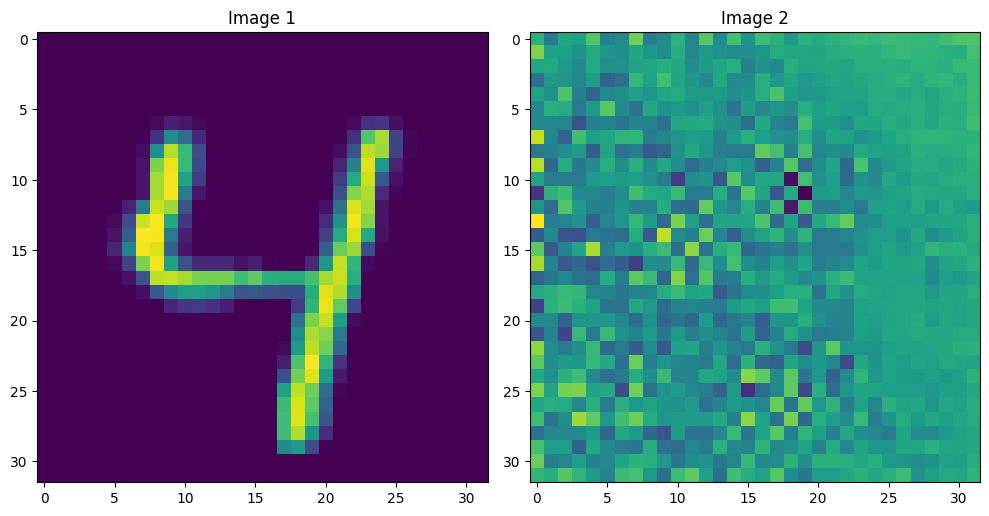

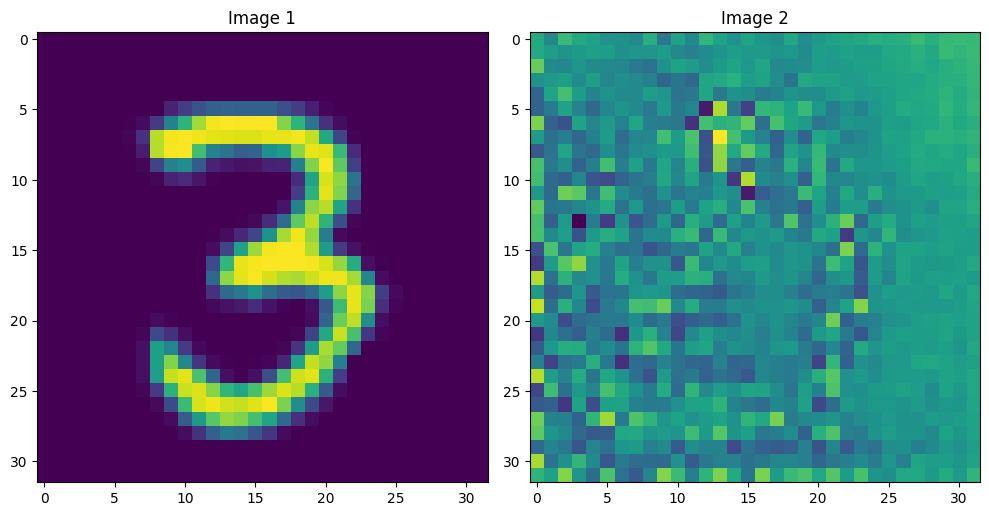

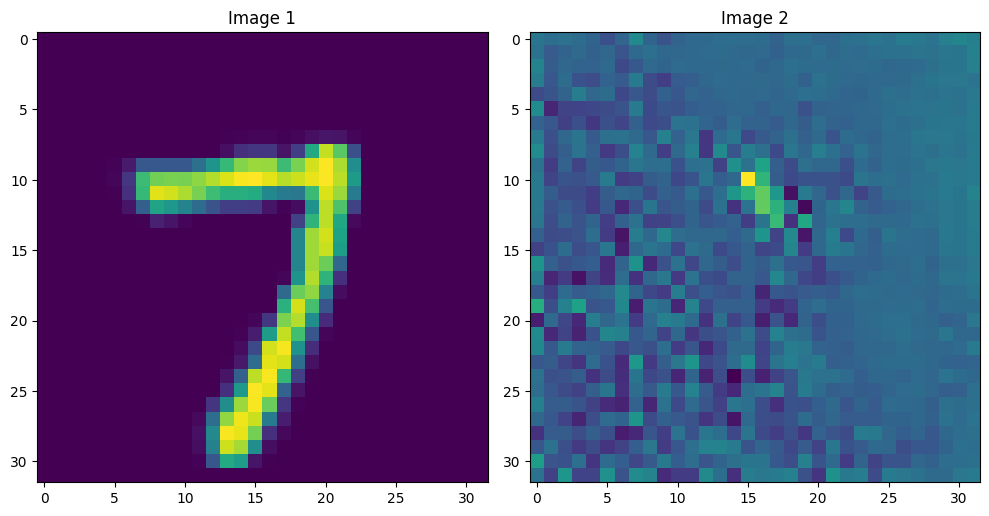

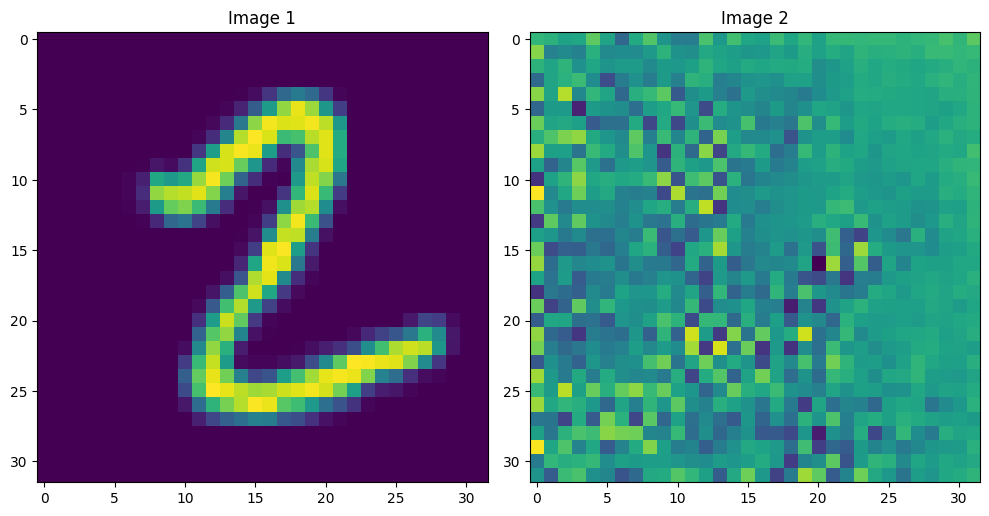

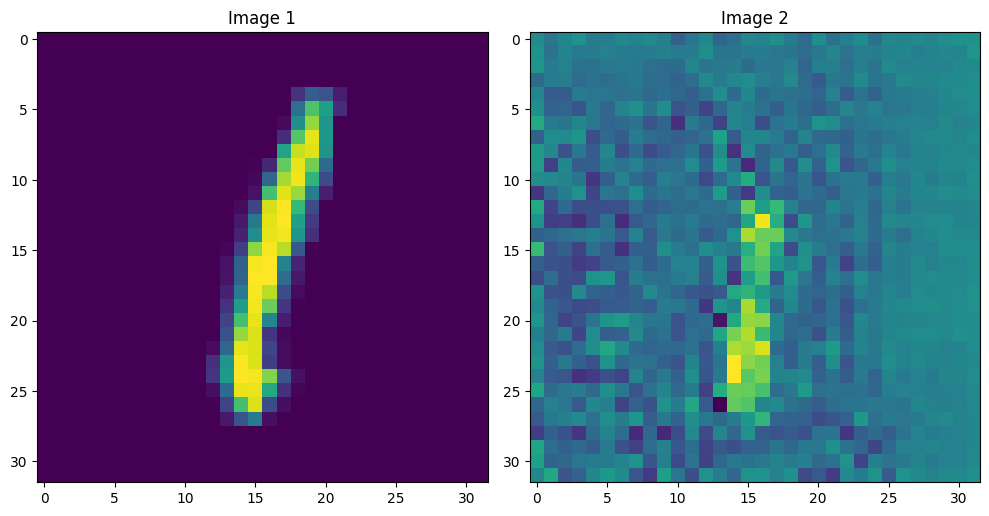

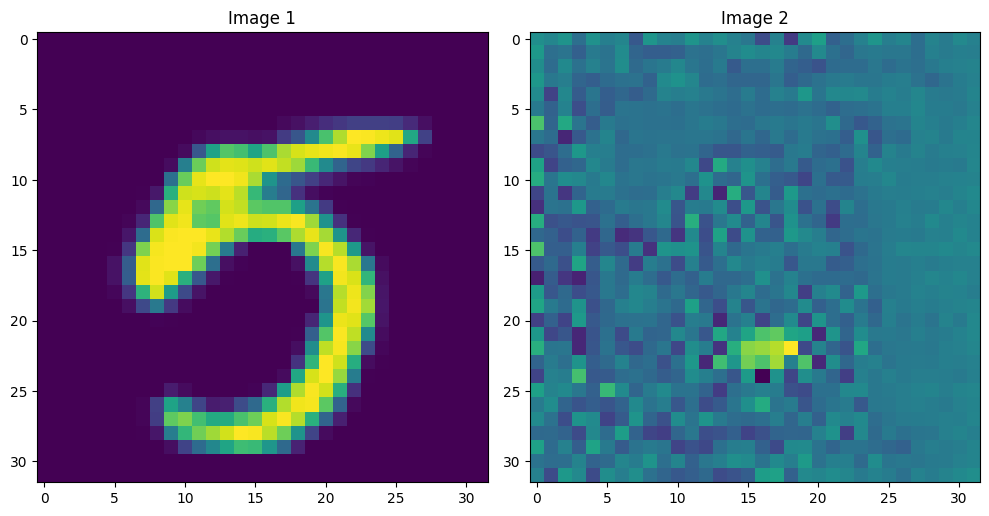

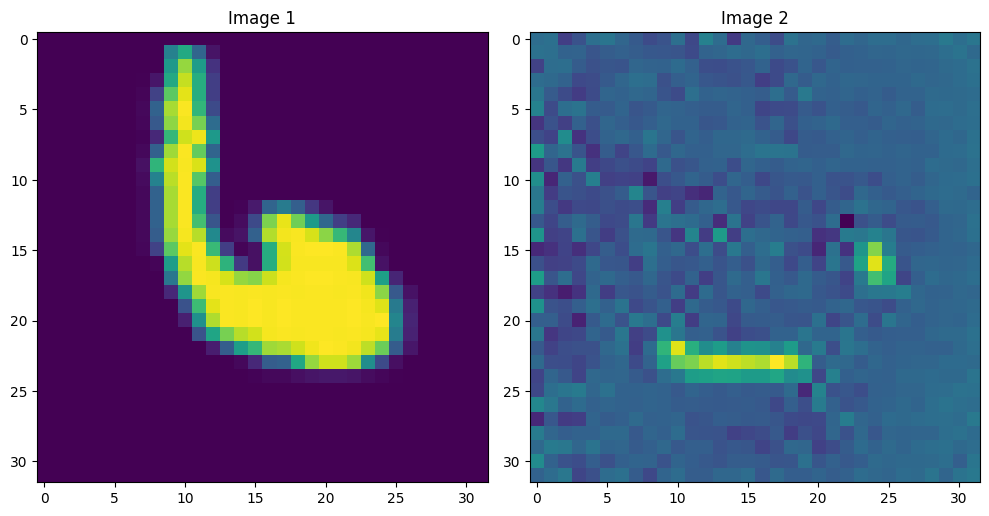

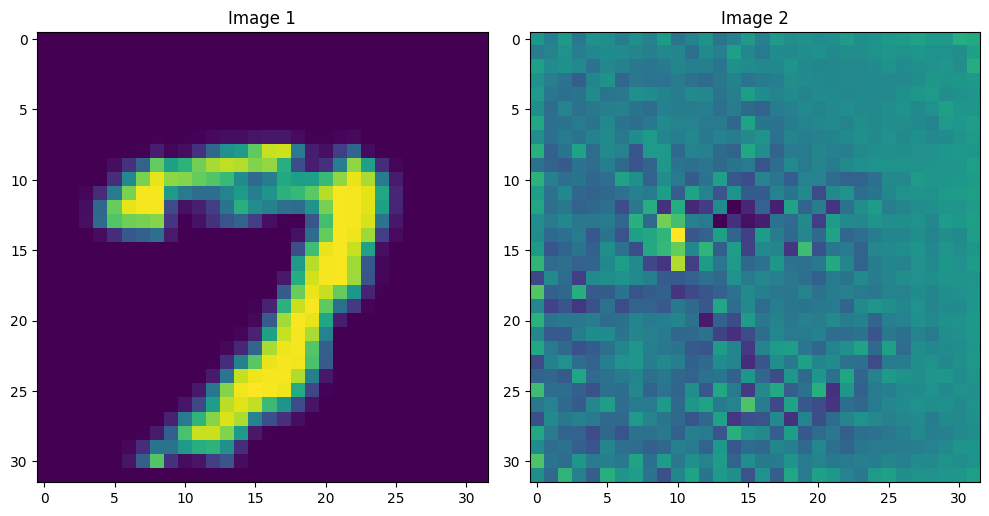

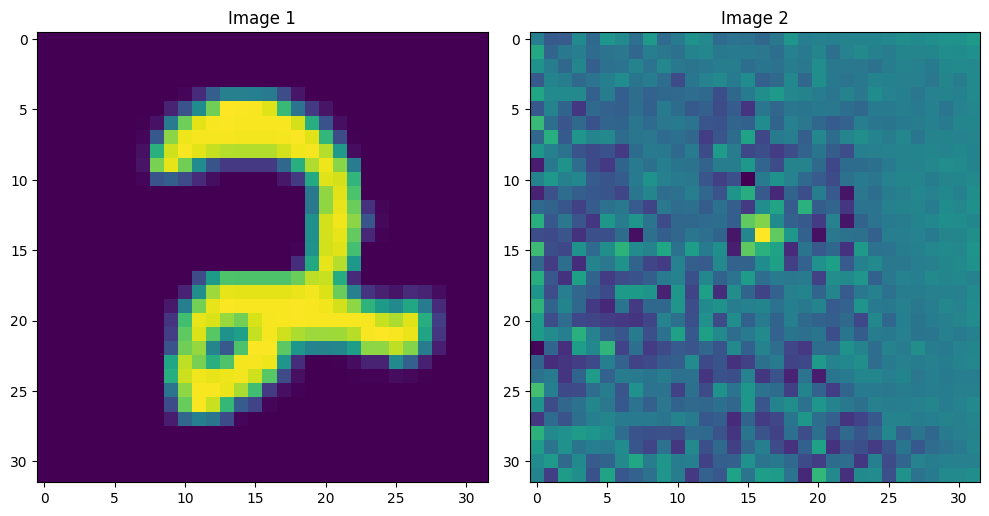

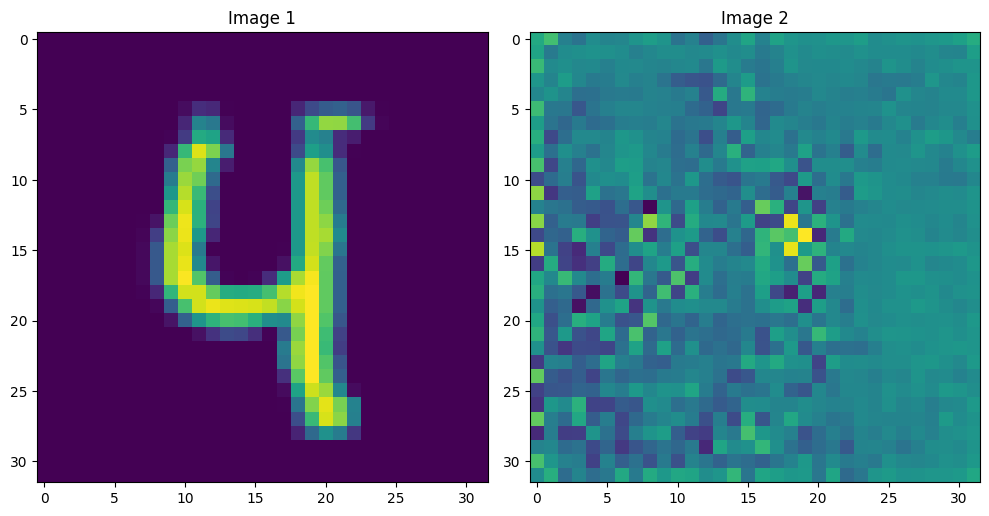

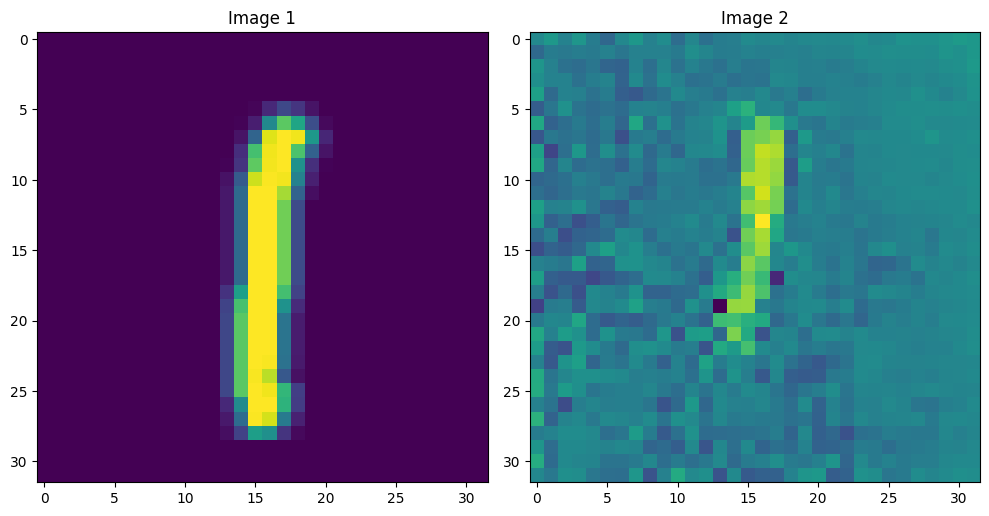

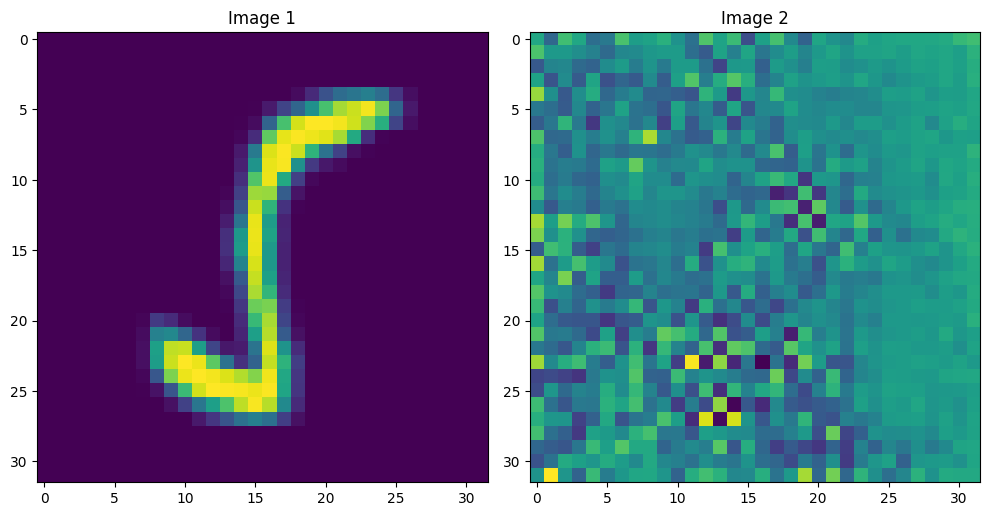

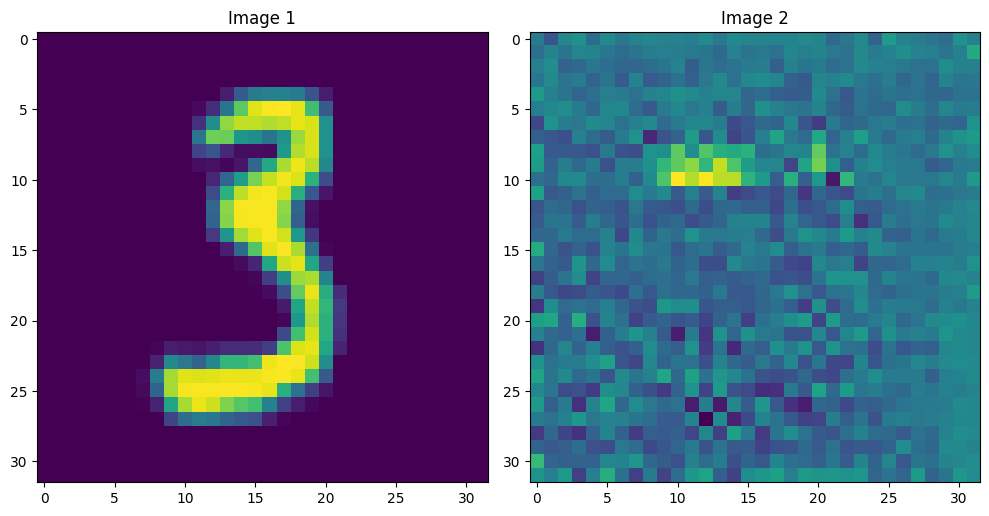

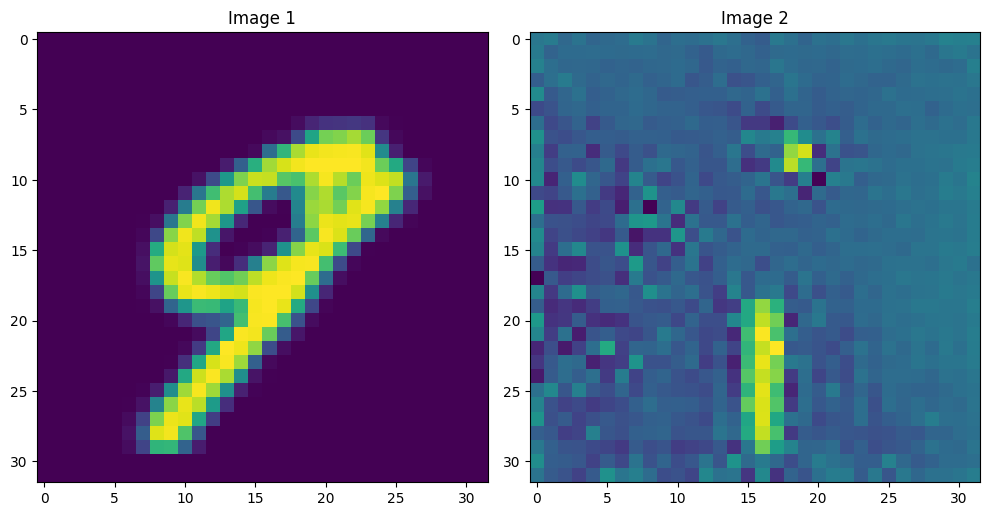

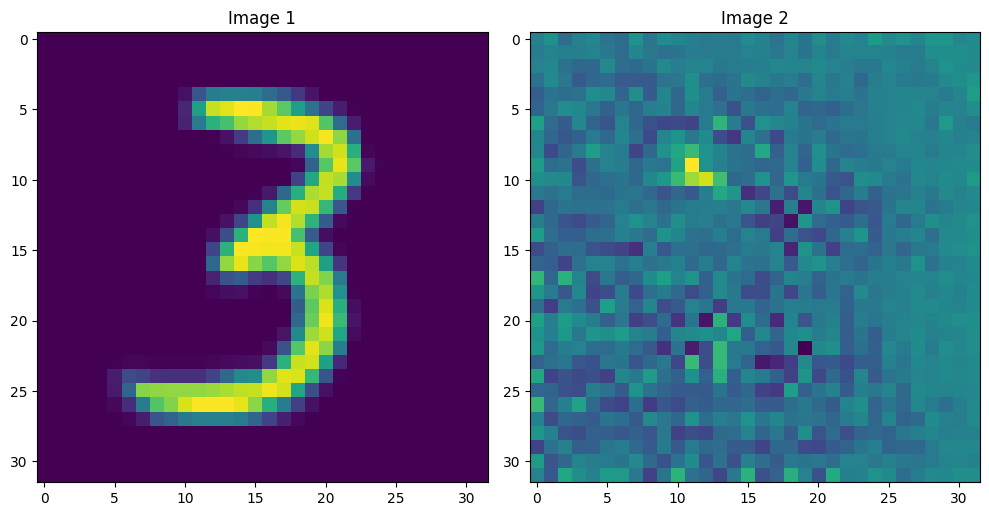

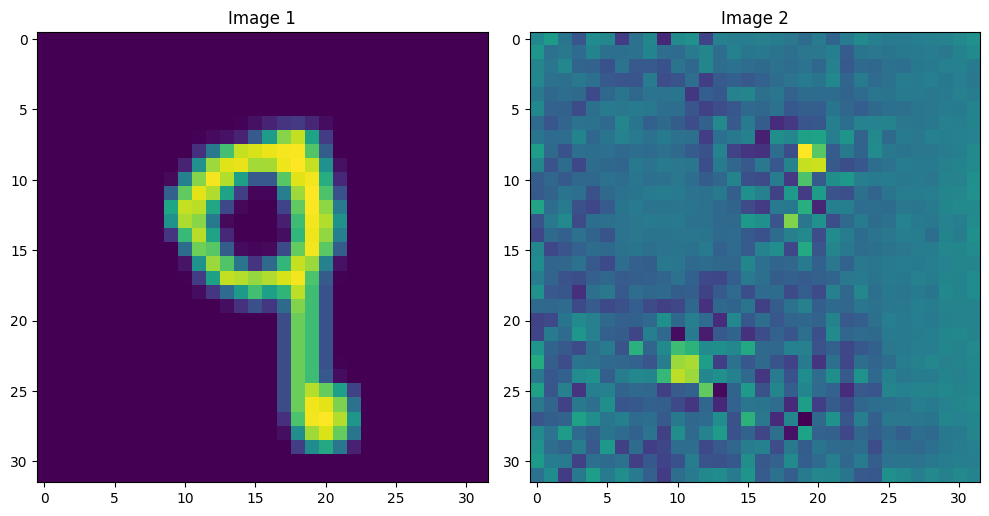

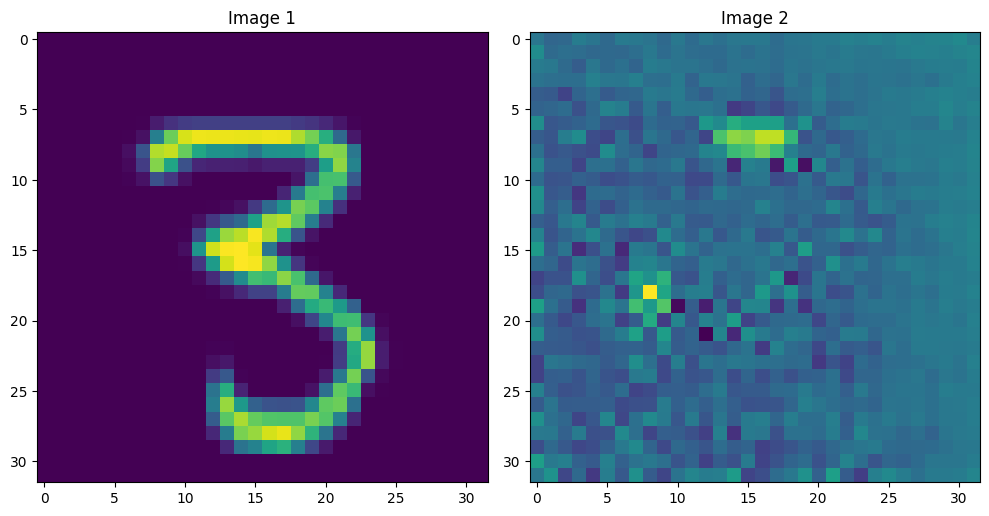

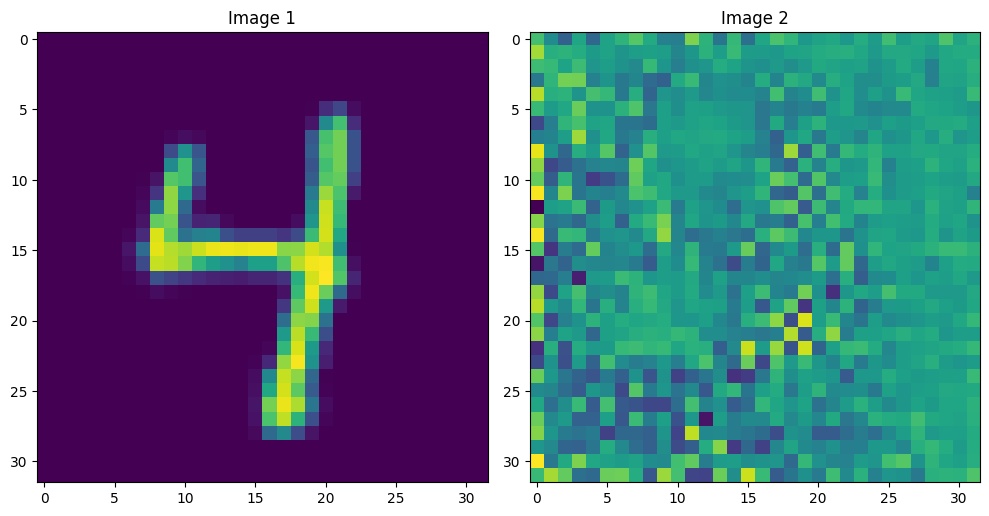

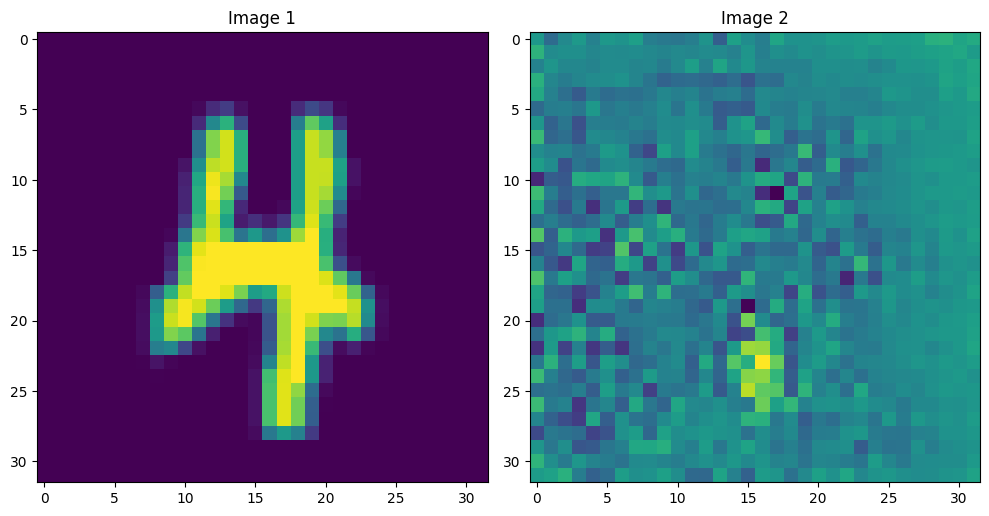

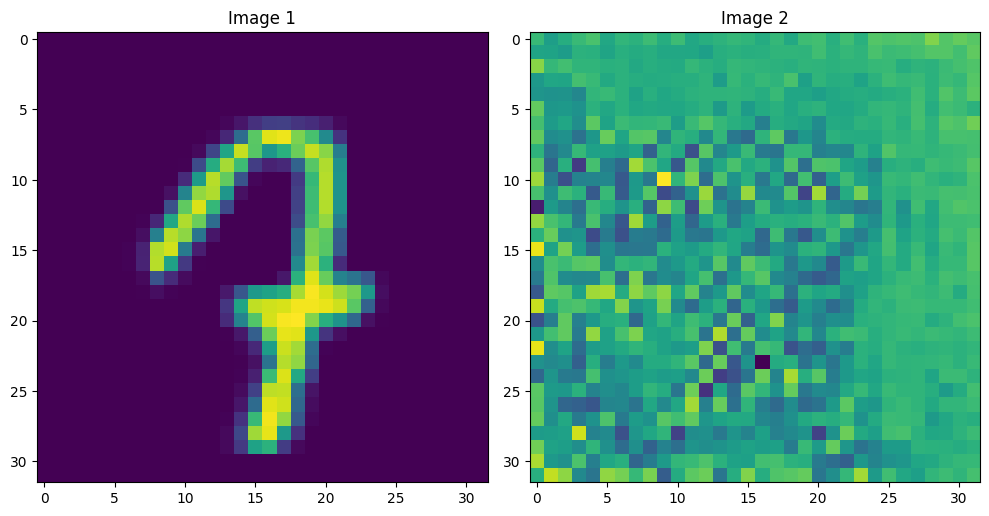

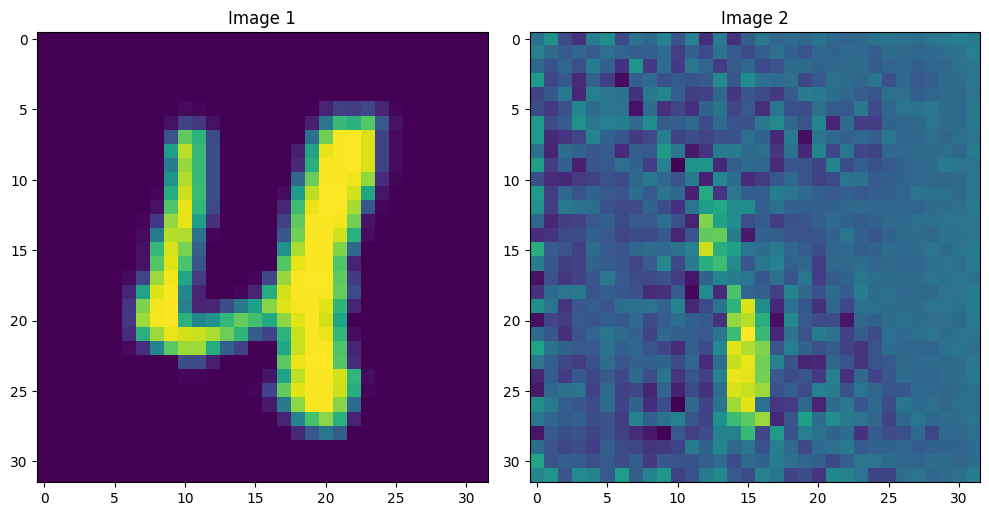

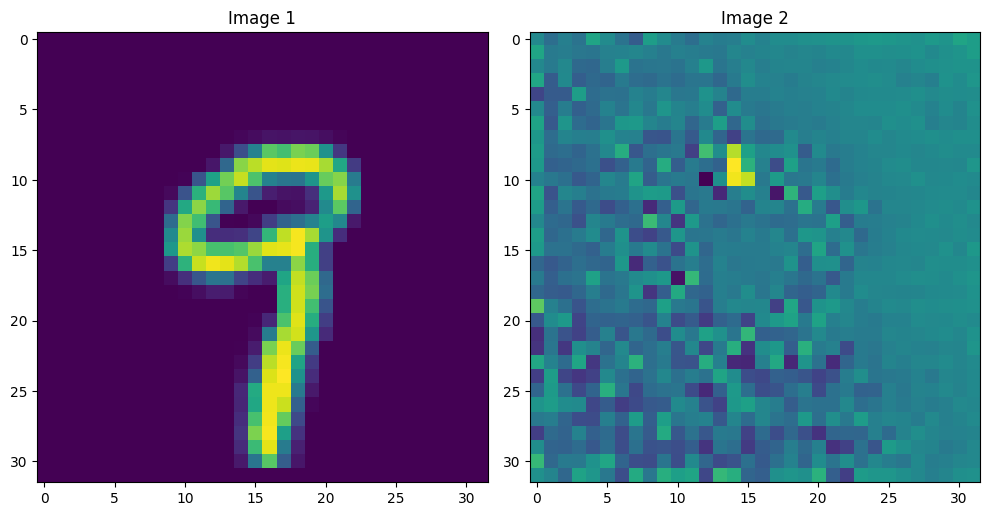

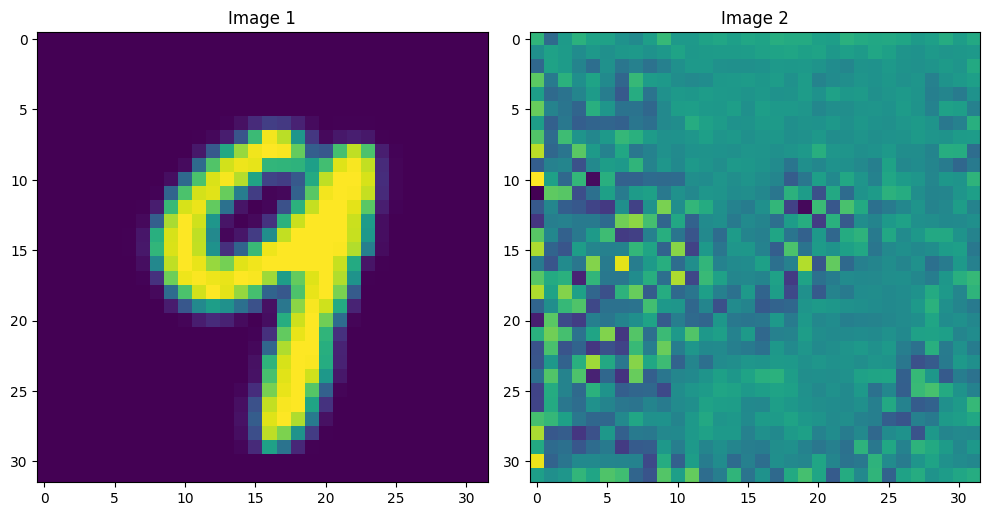

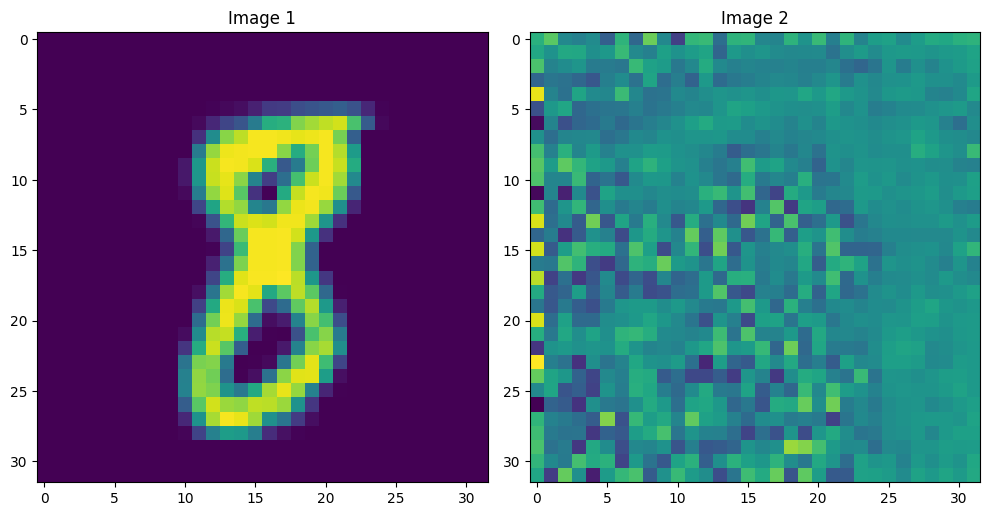

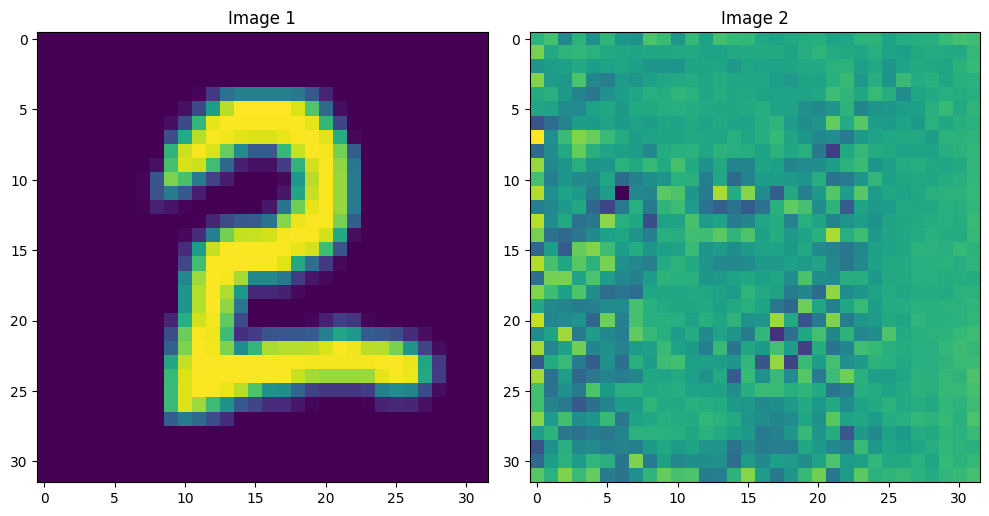

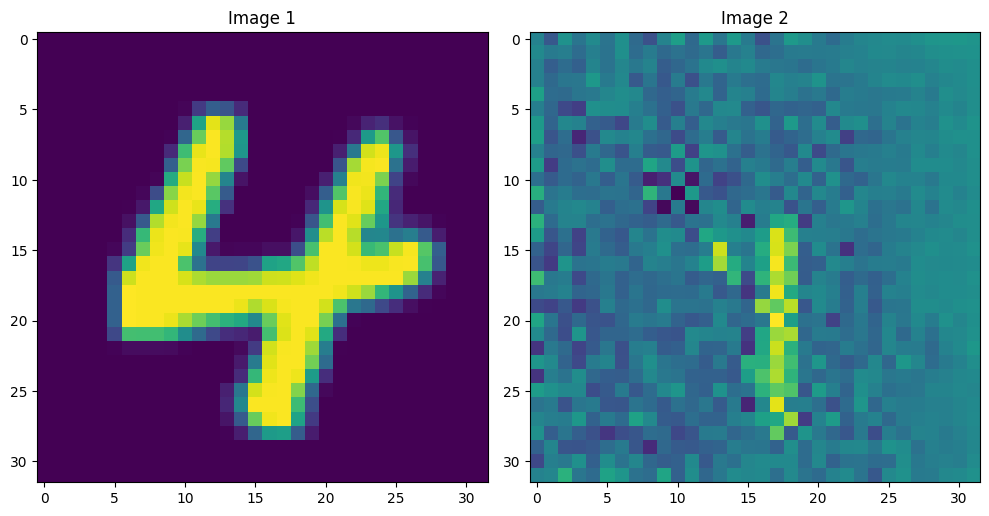

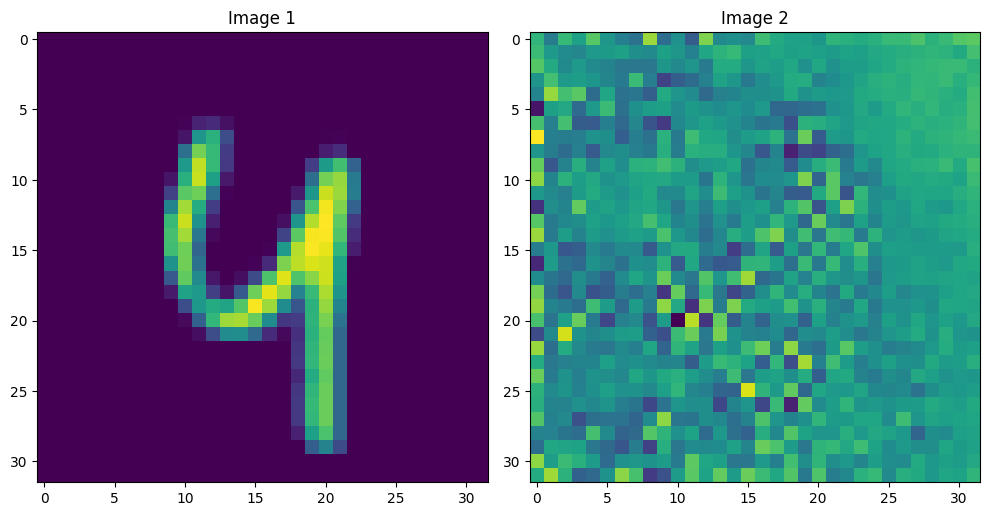

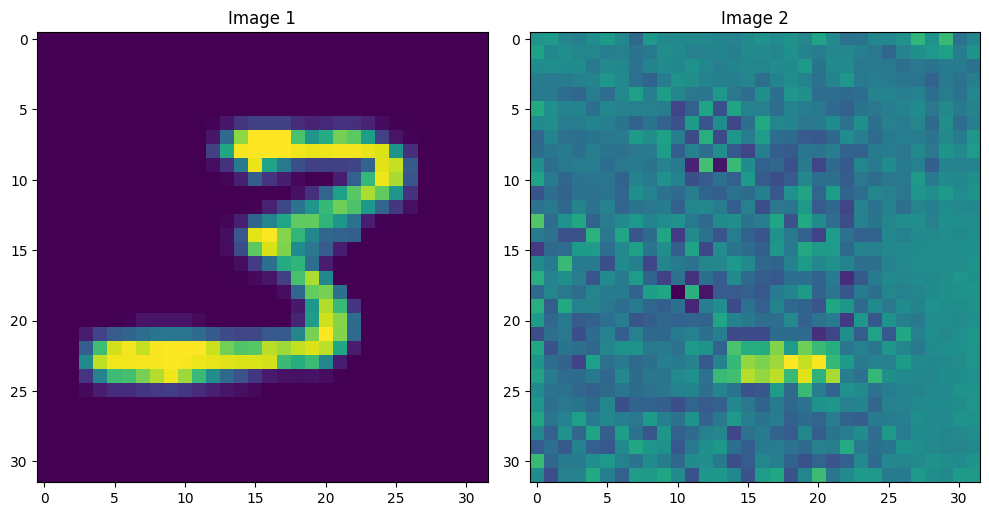

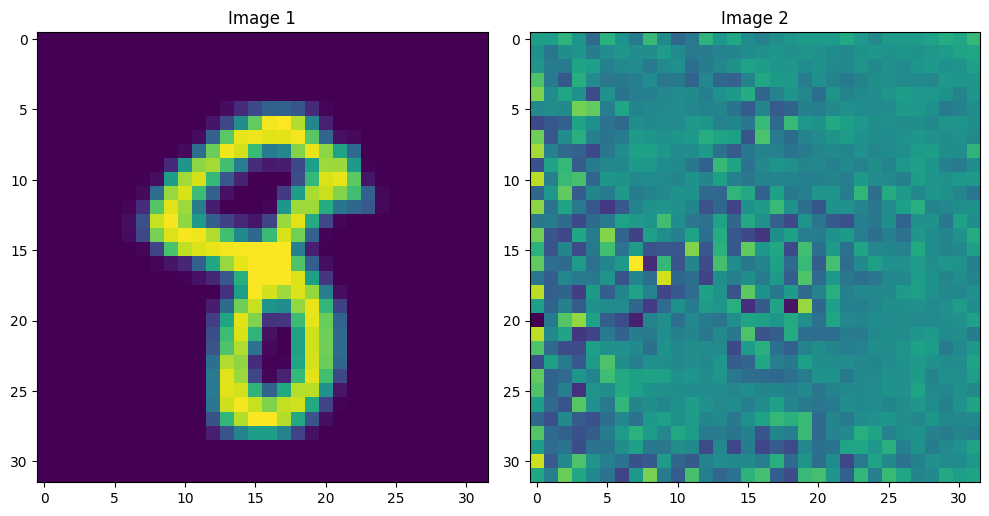

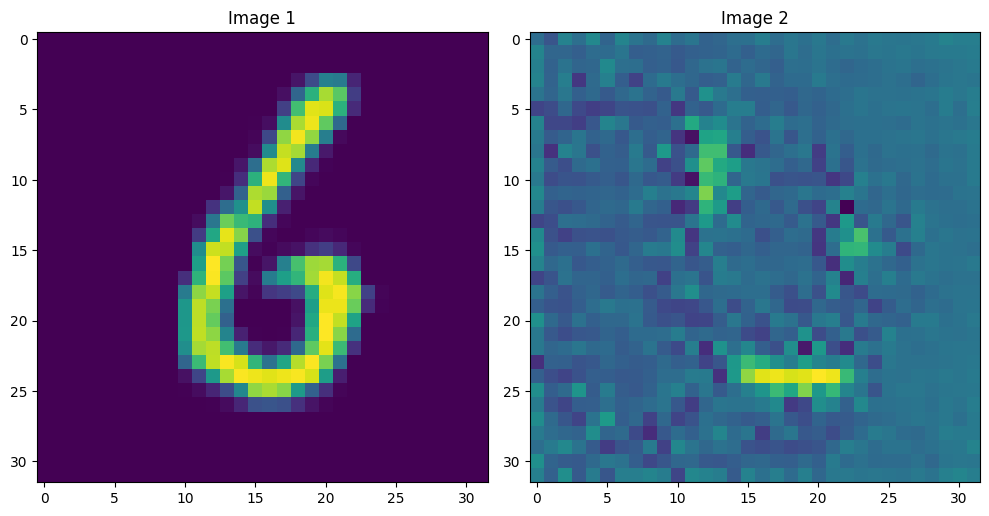

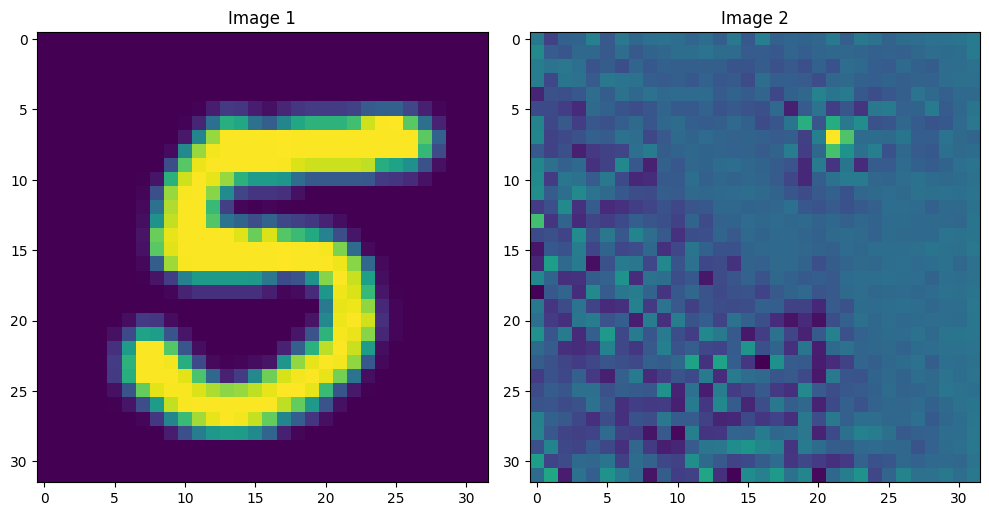

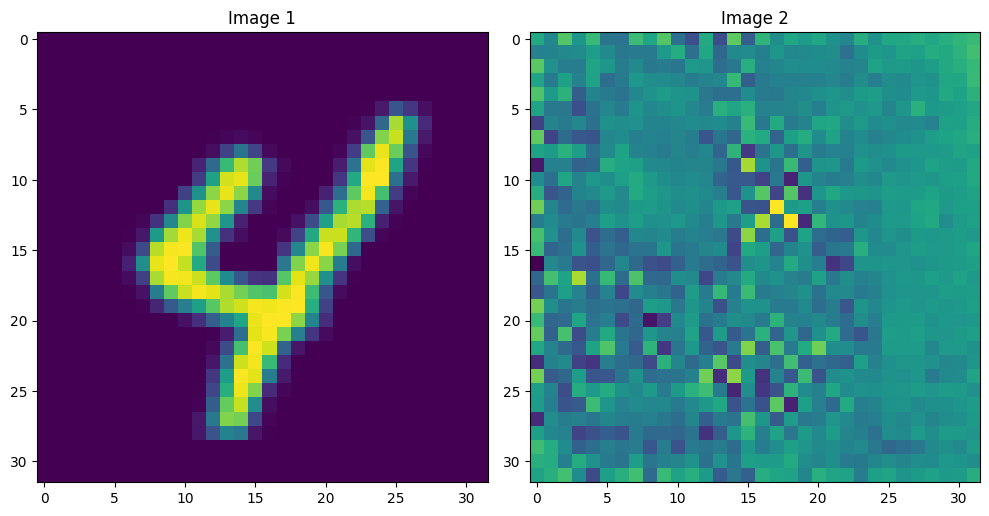

In [ ]:
print_result(result_DDPM)

# Sampling: DDIM

In [71]:
result_DDIM = model.evaluate(
    epochs=5,
    sampling_type='DDIM',
    sampling_time_step=100,
    w=0
)
# [num, 3, B, 1, 32, 32]

  0%|          | 4/1250 [01:01<5:18:05, 15.32s/it]


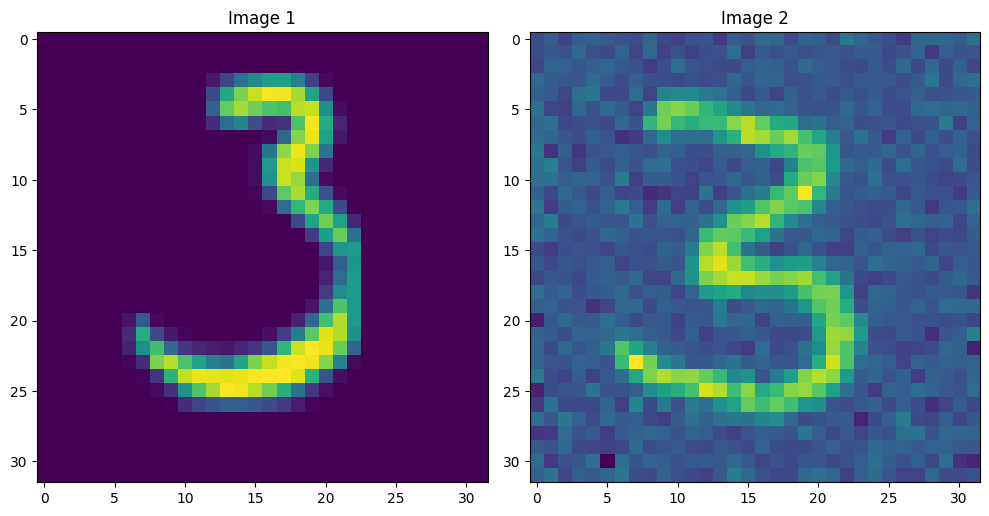

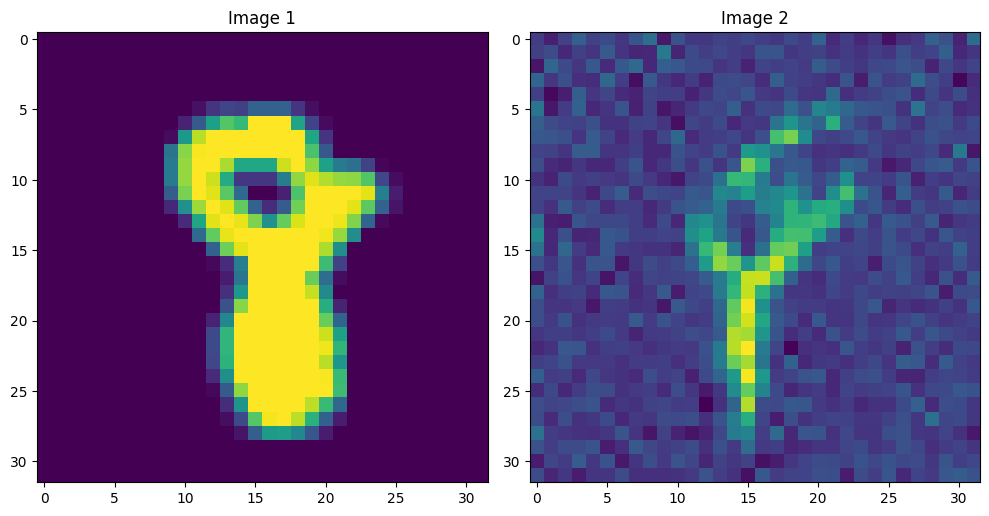

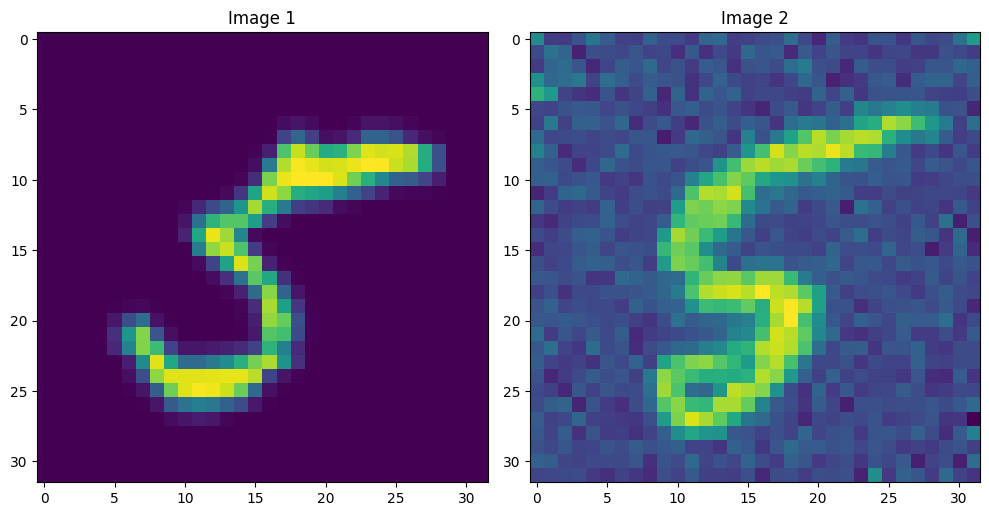

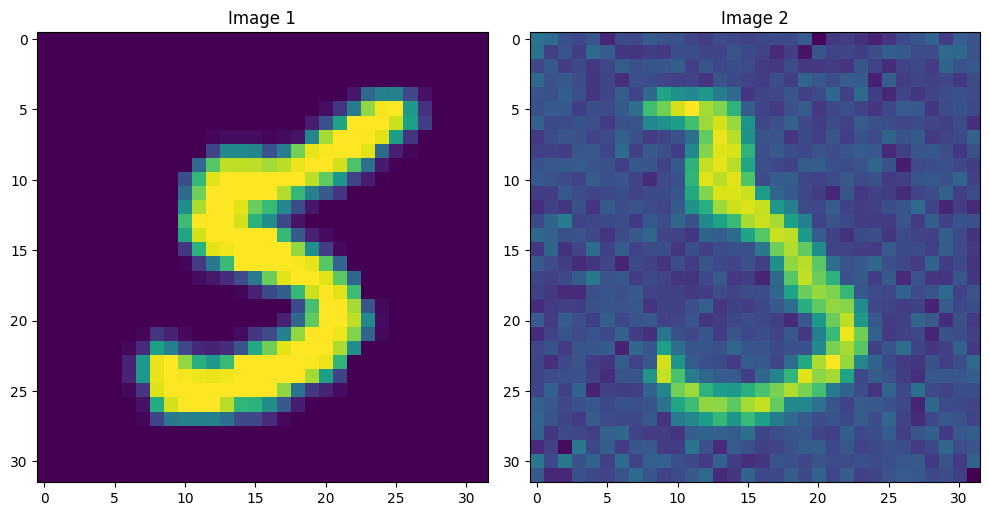

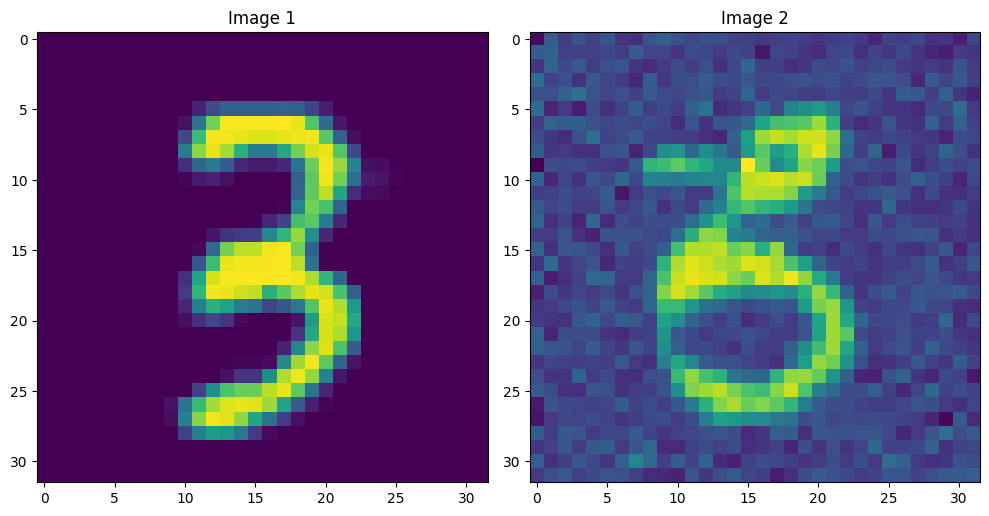

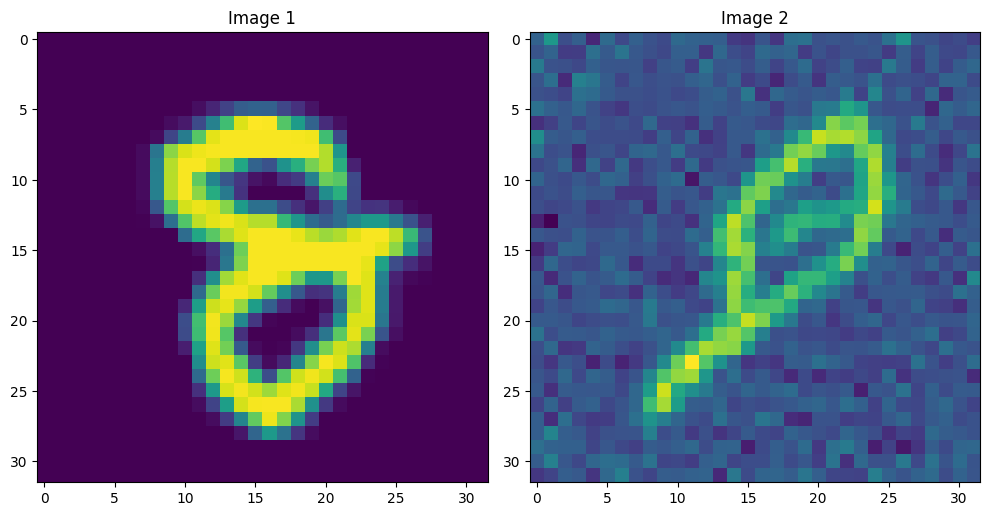

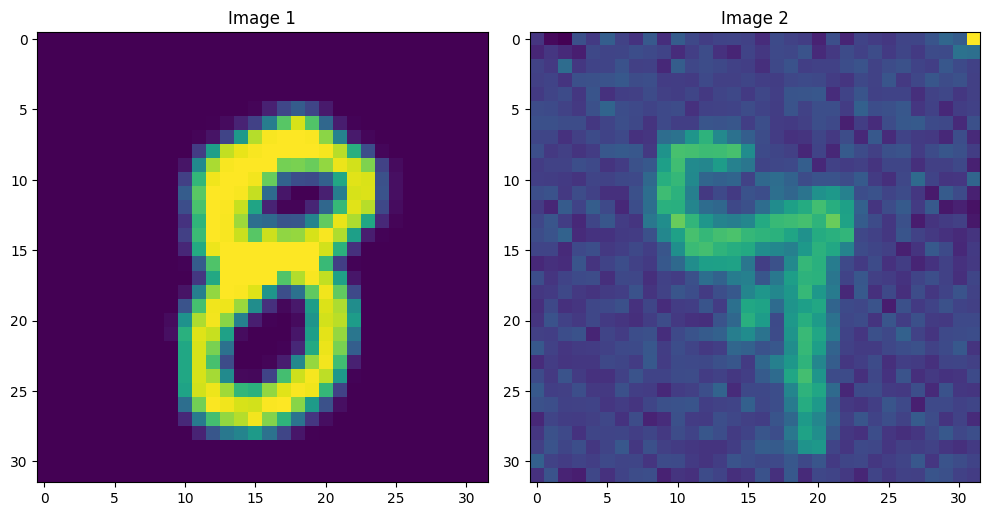

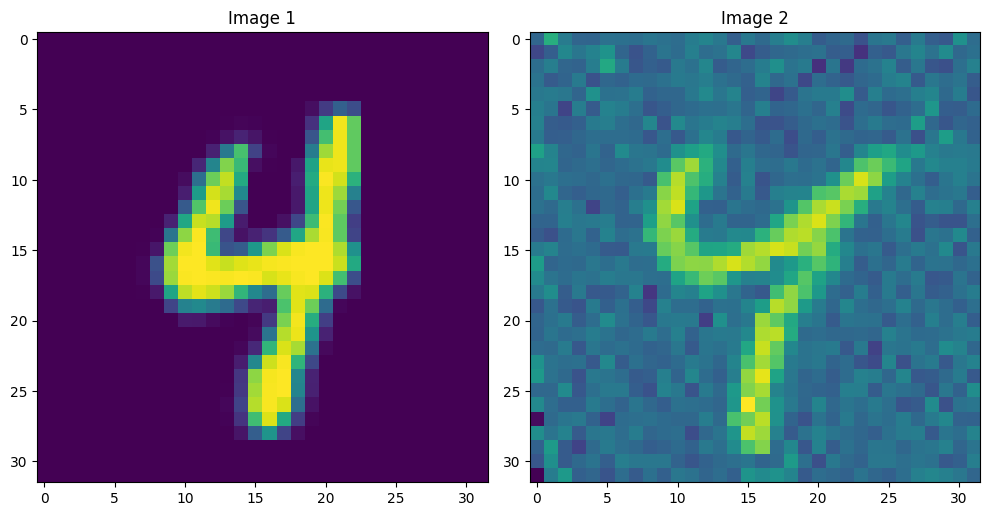

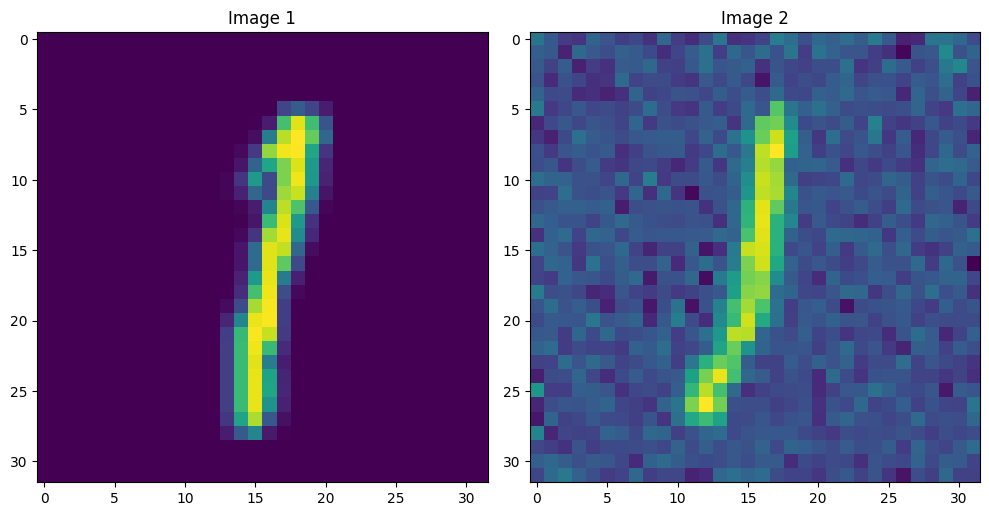

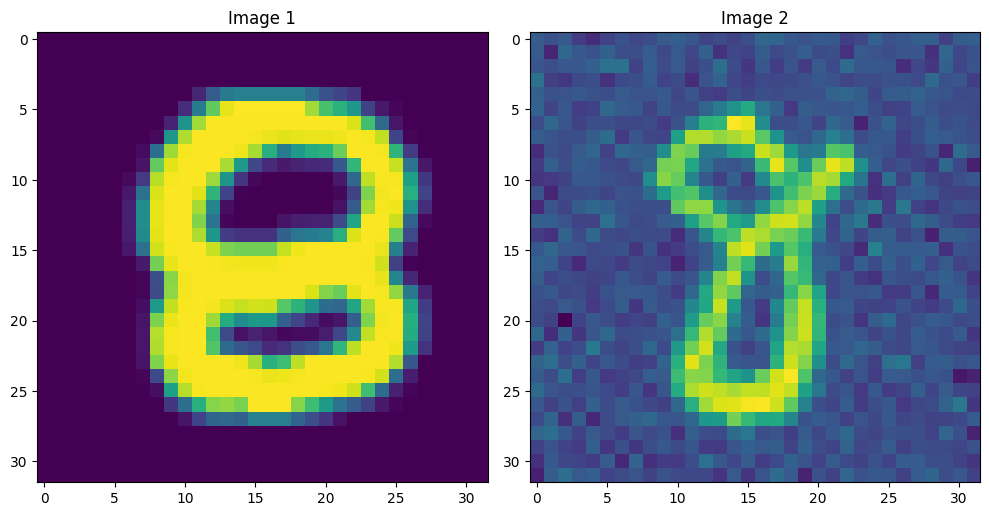

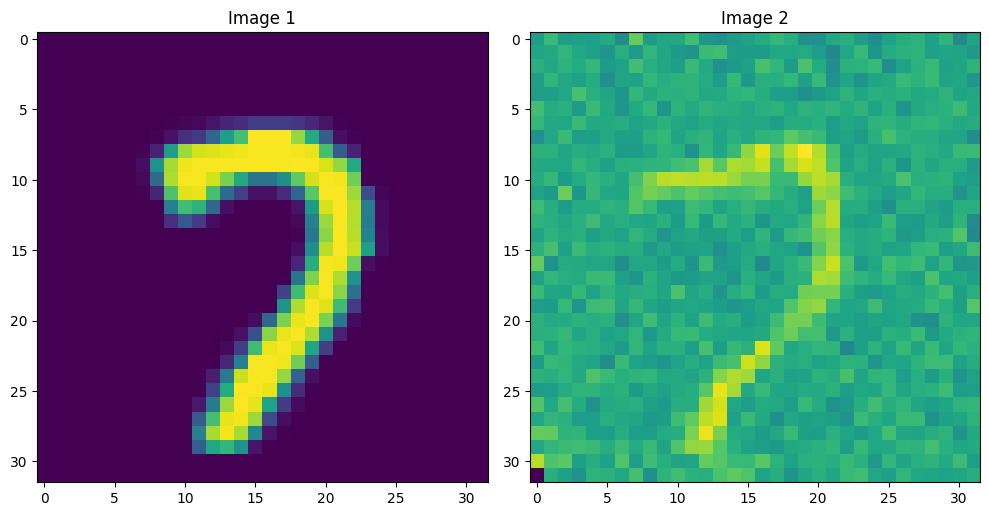

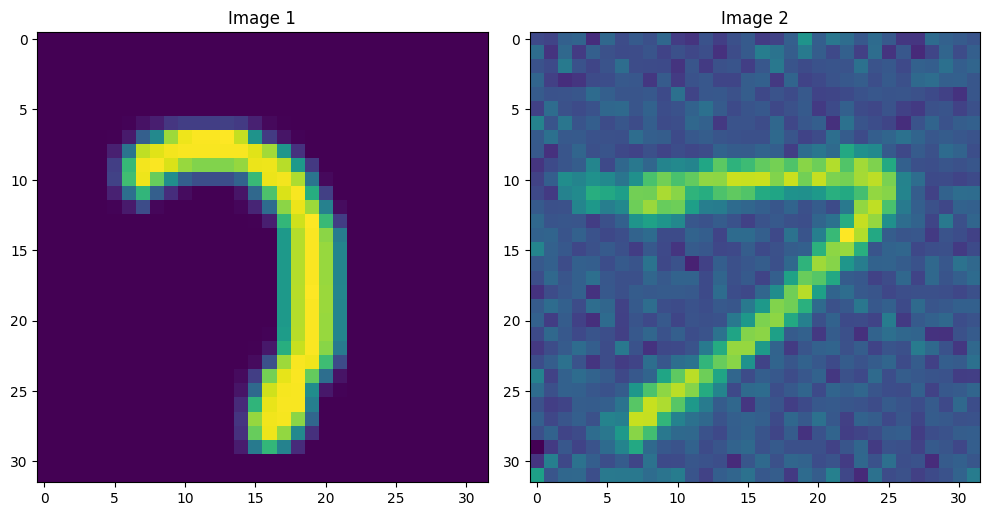

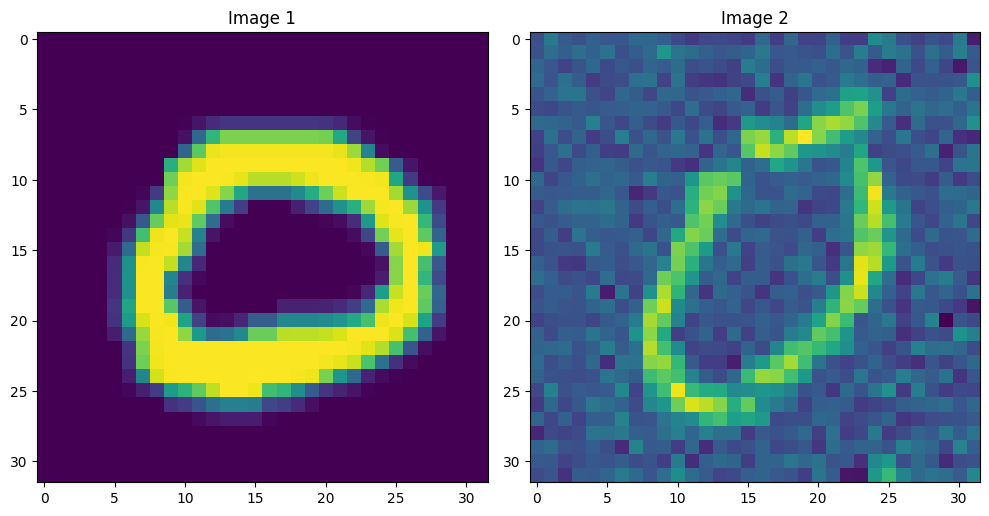

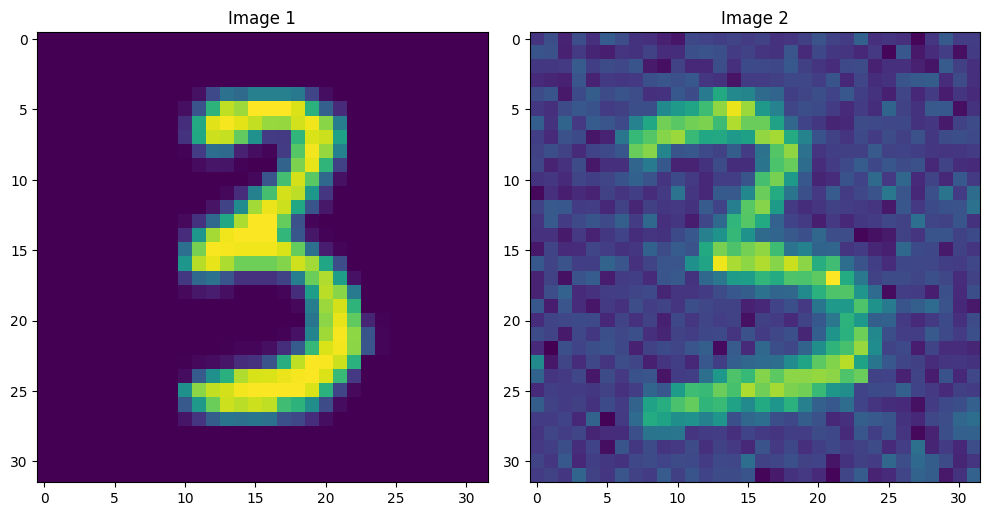

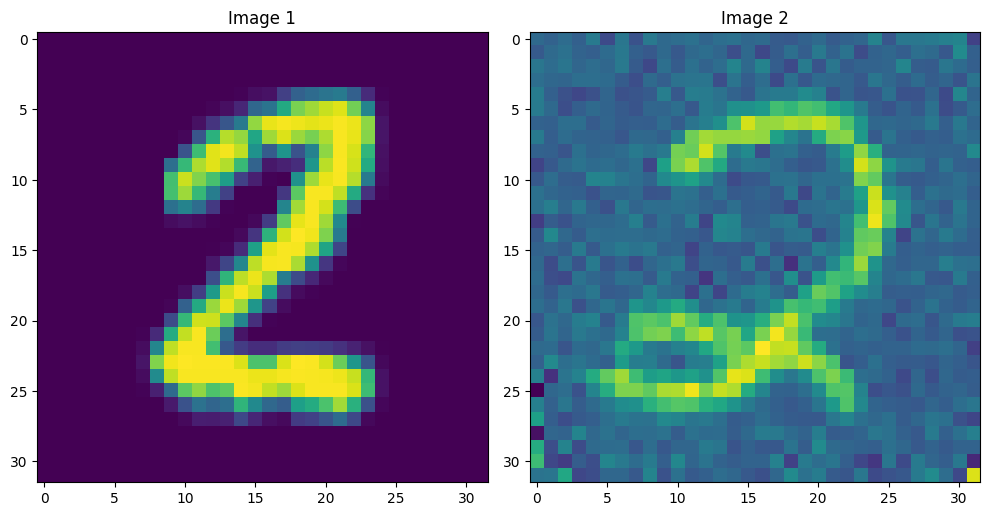

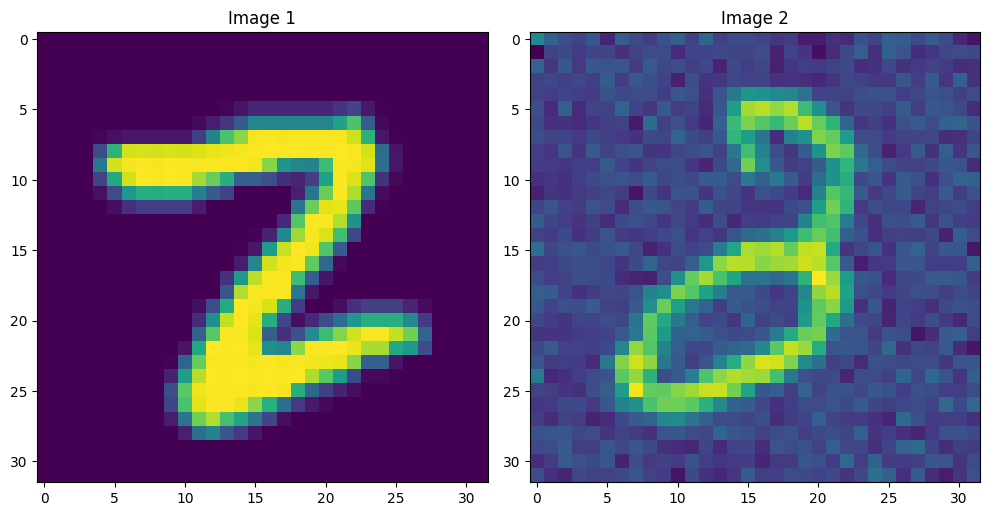

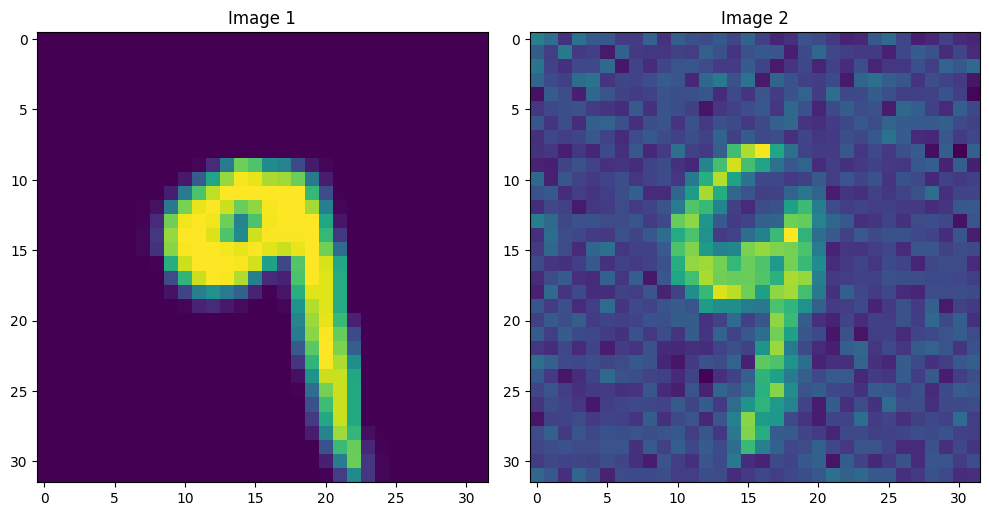

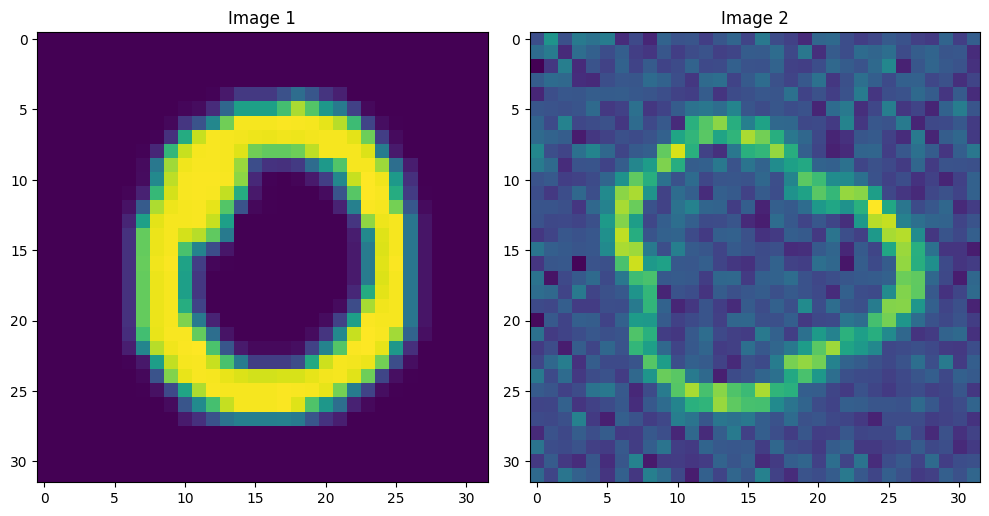

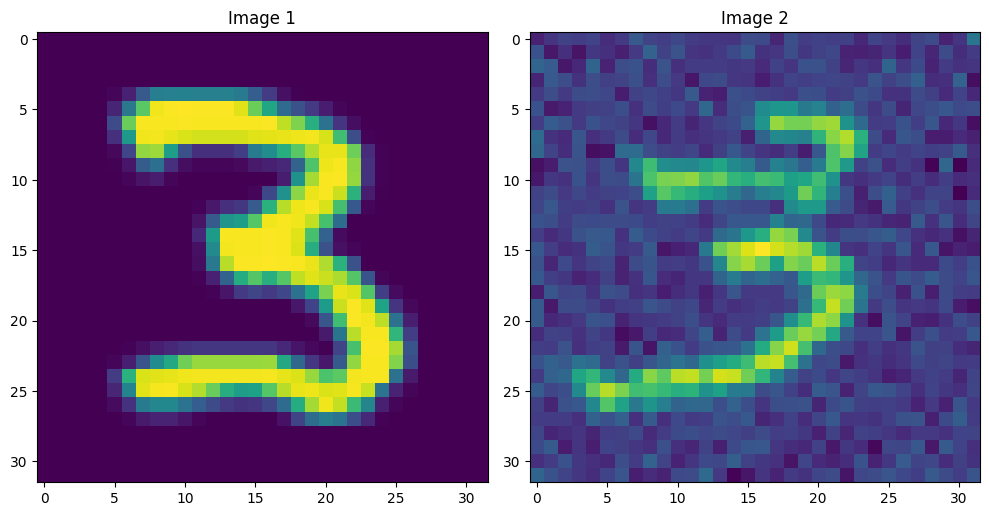

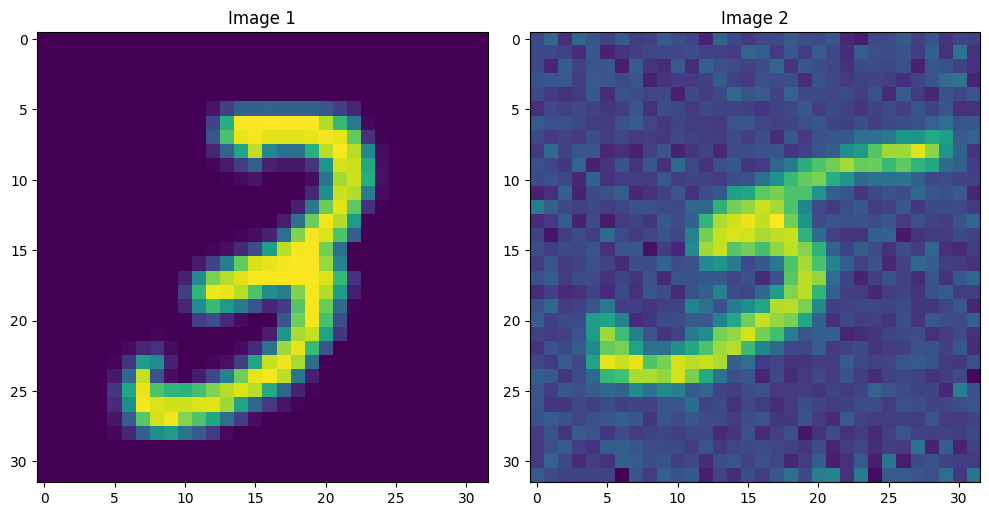

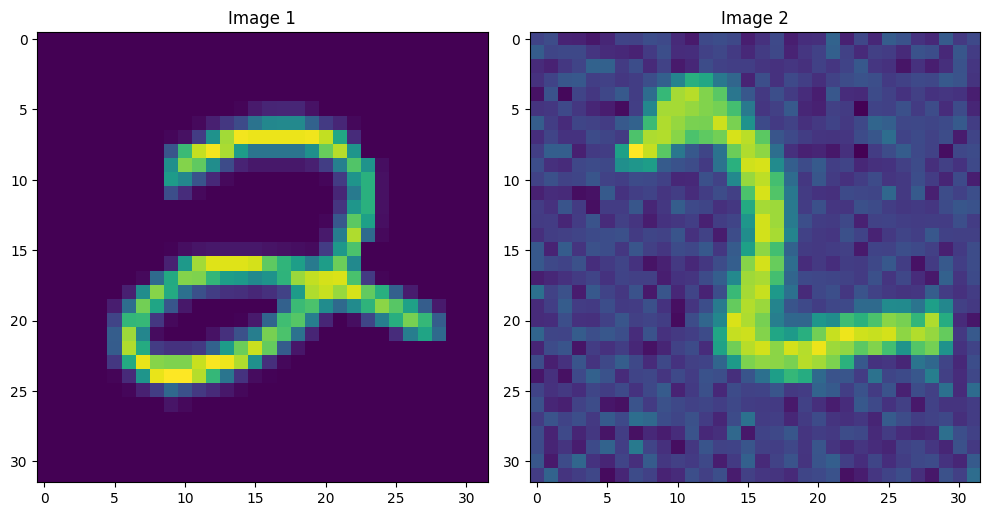

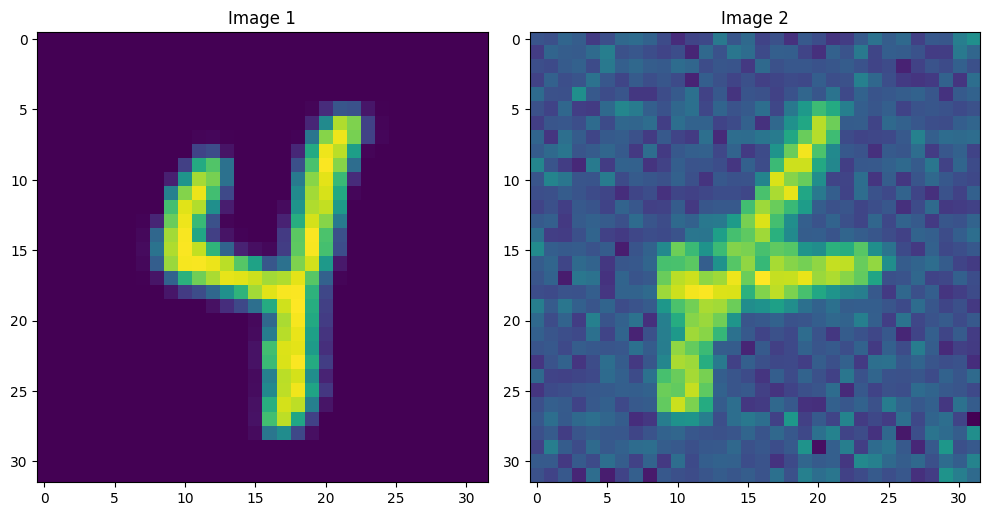

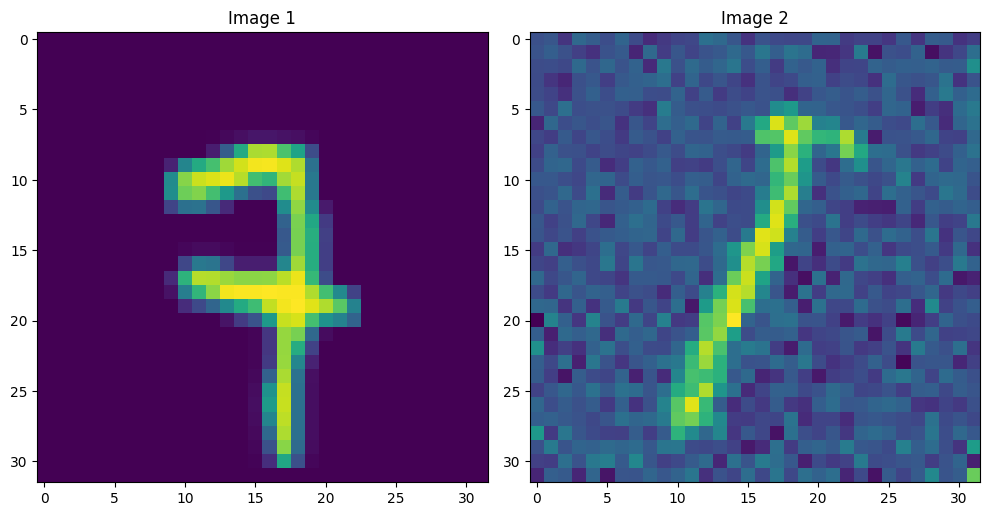

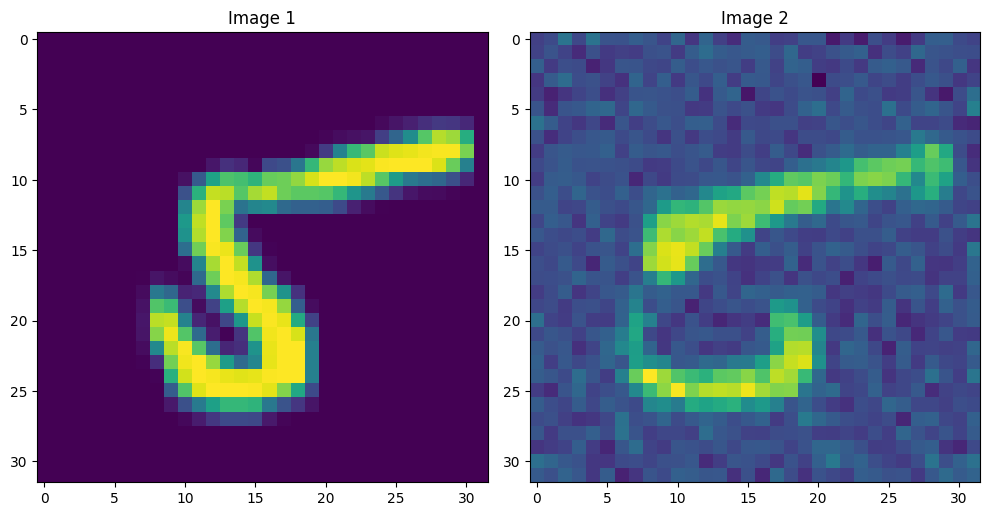

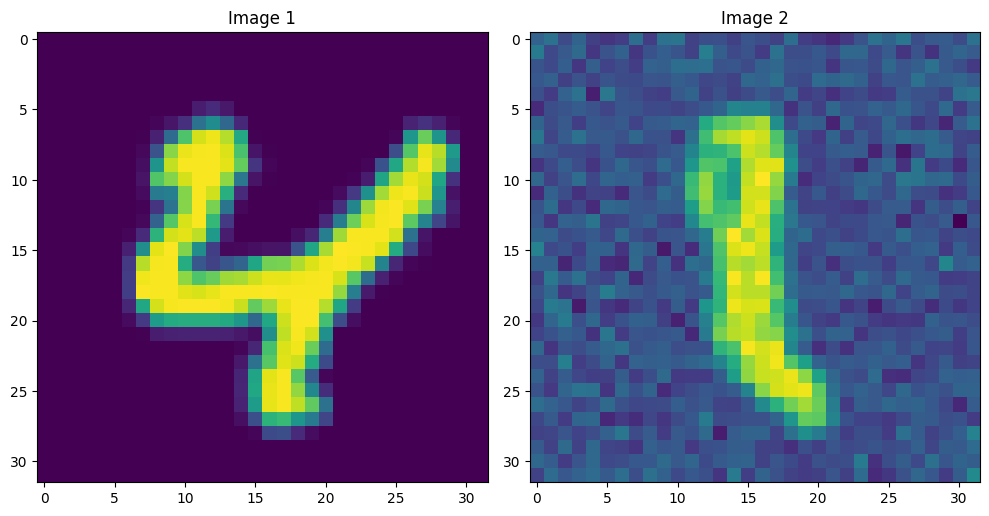

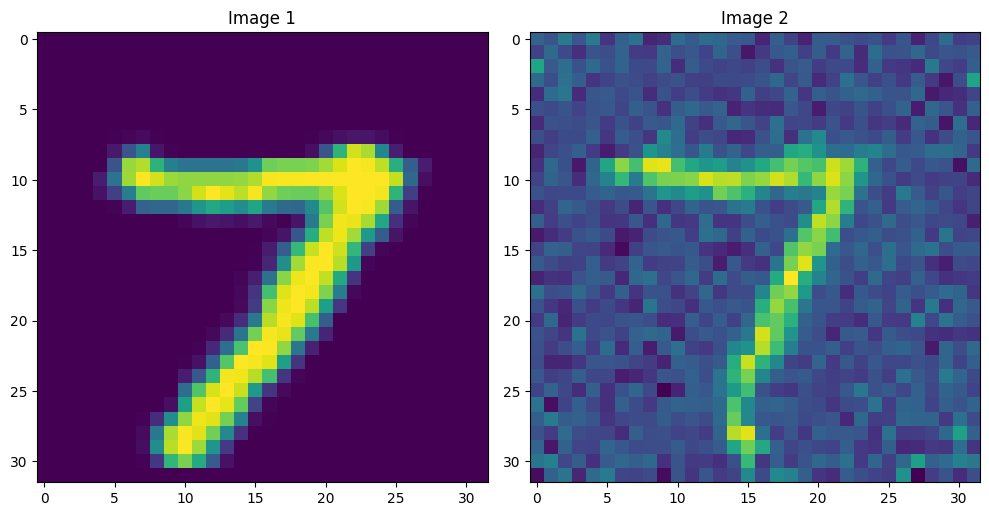

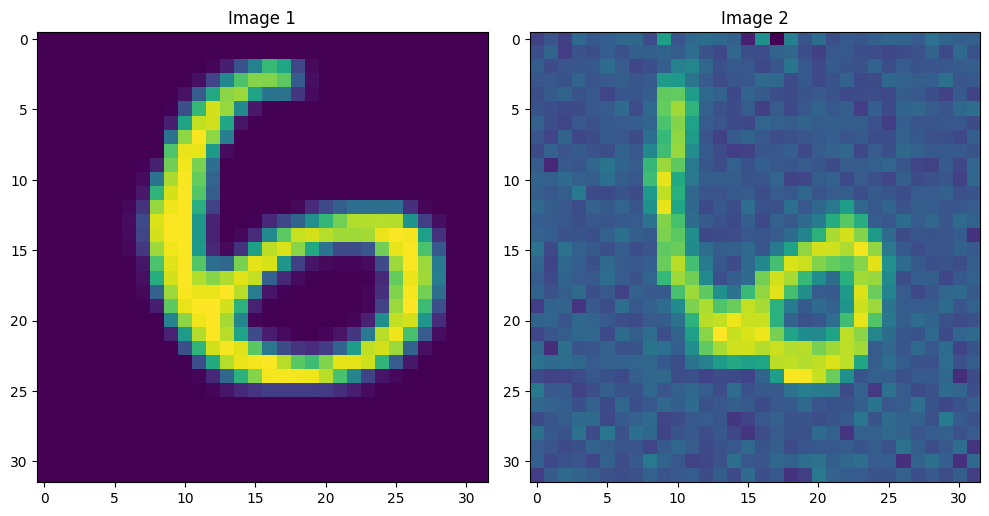

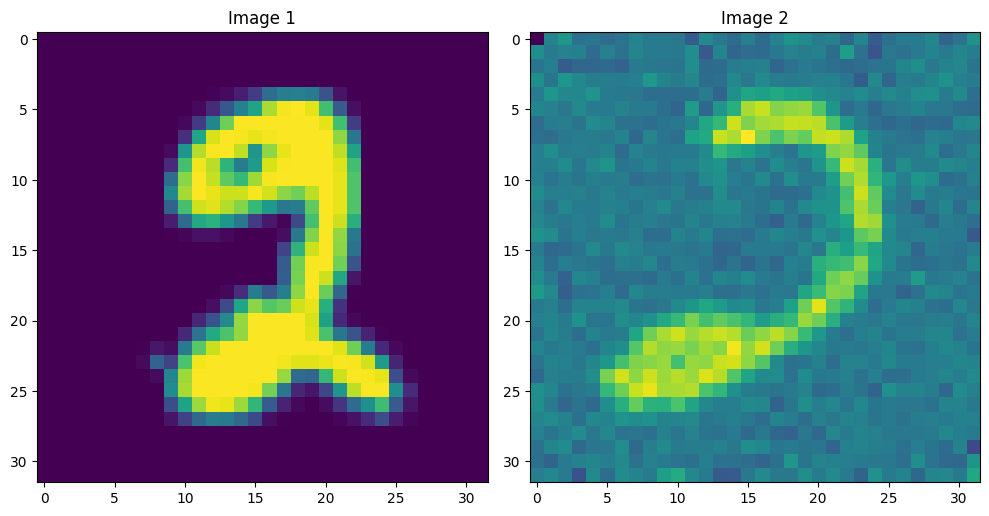

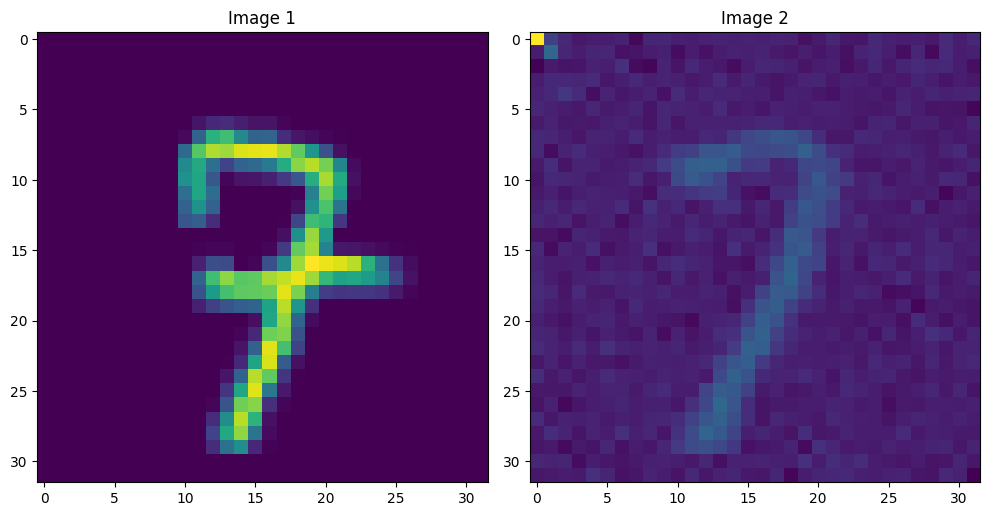

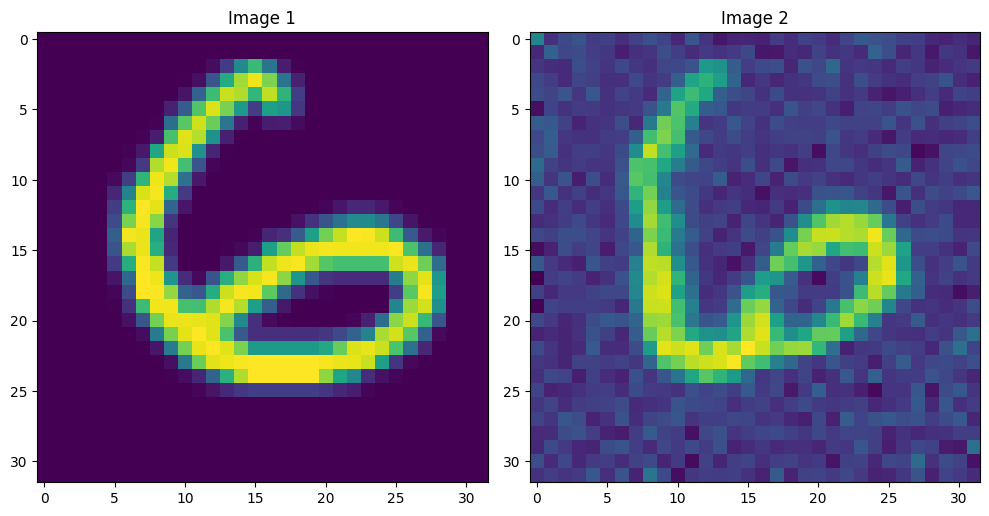

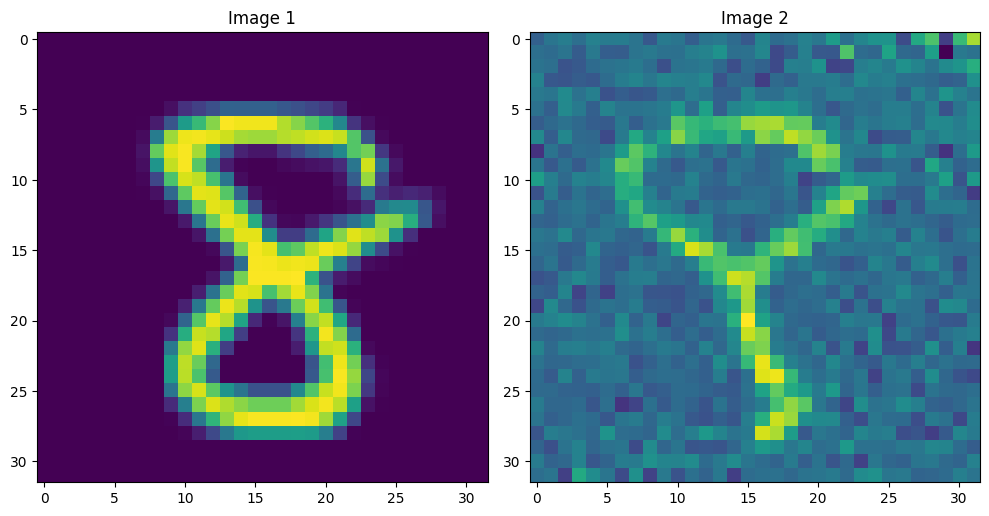

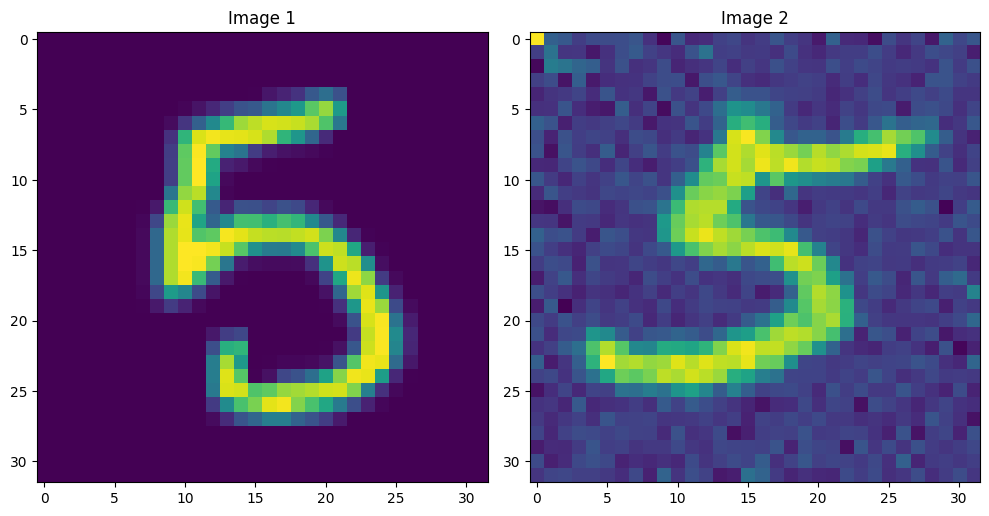

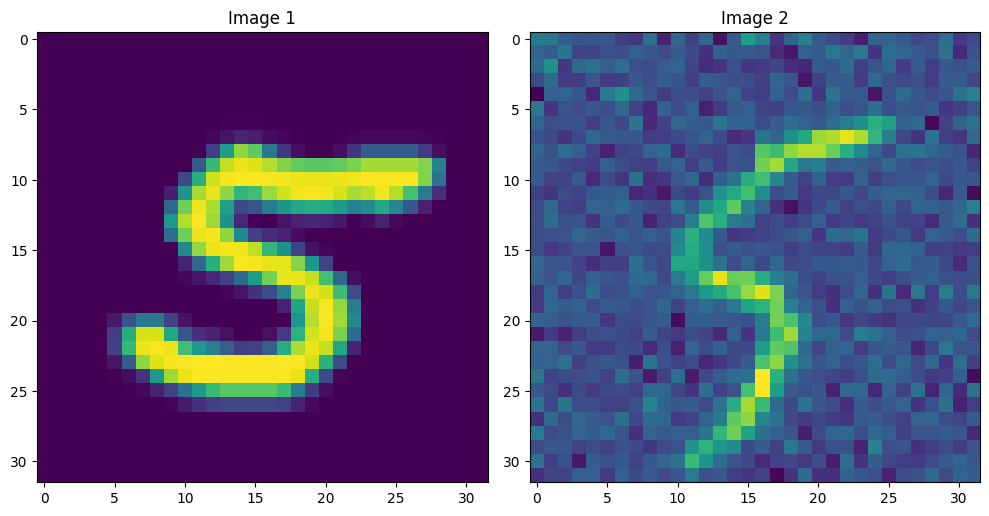

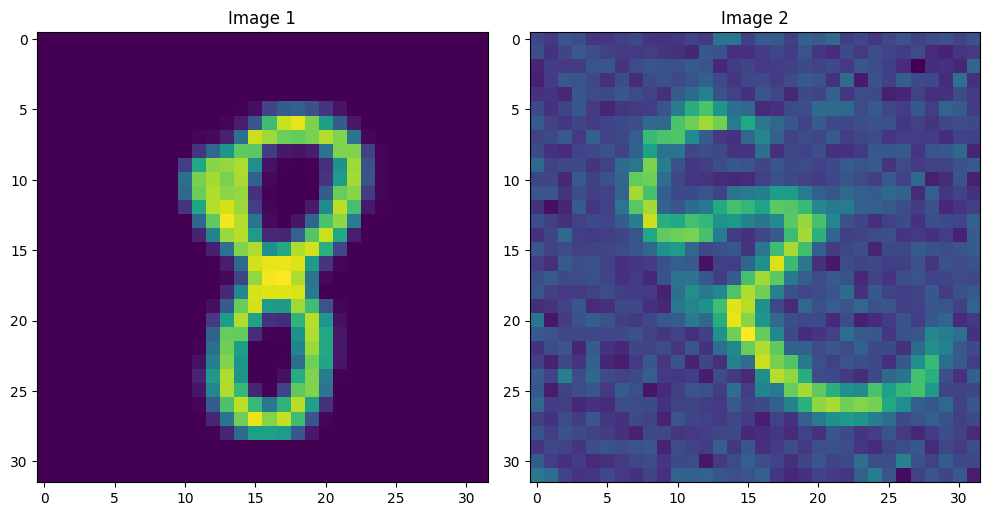

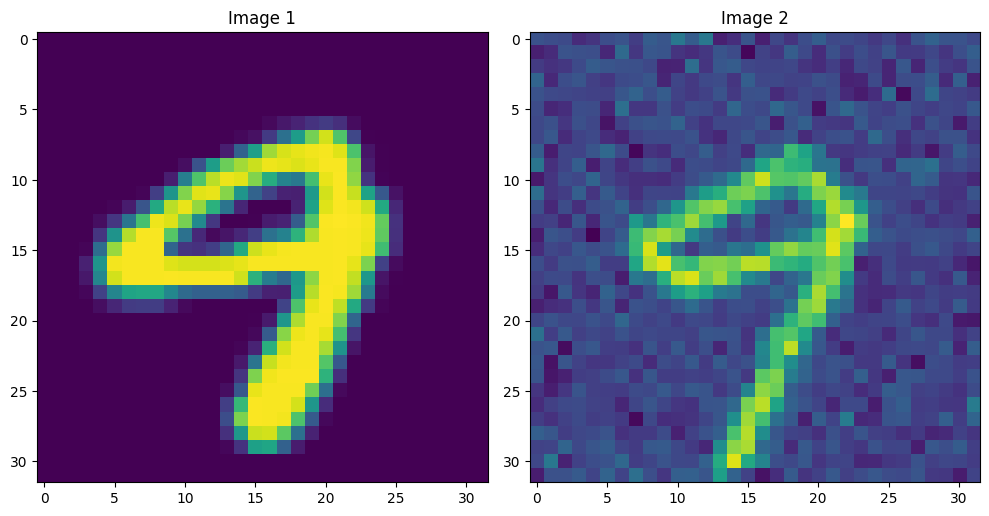

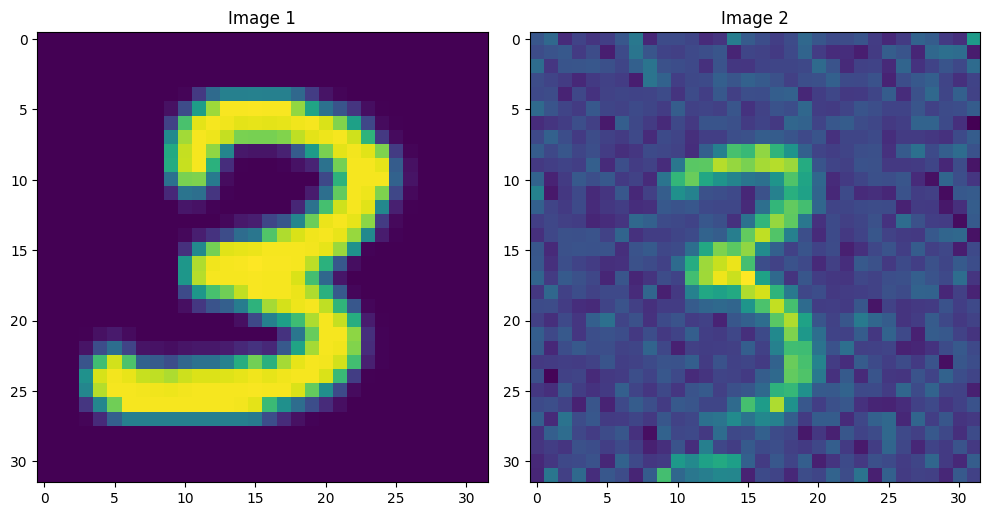

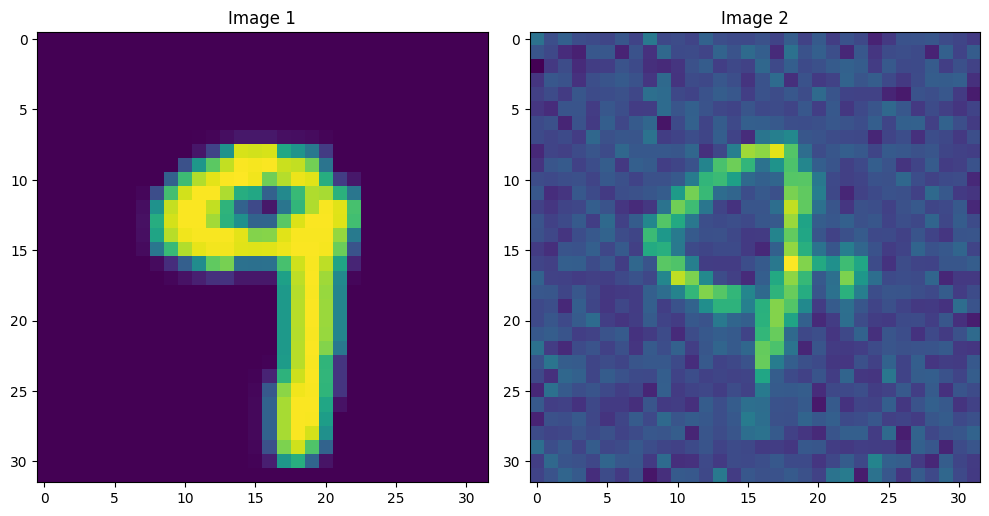

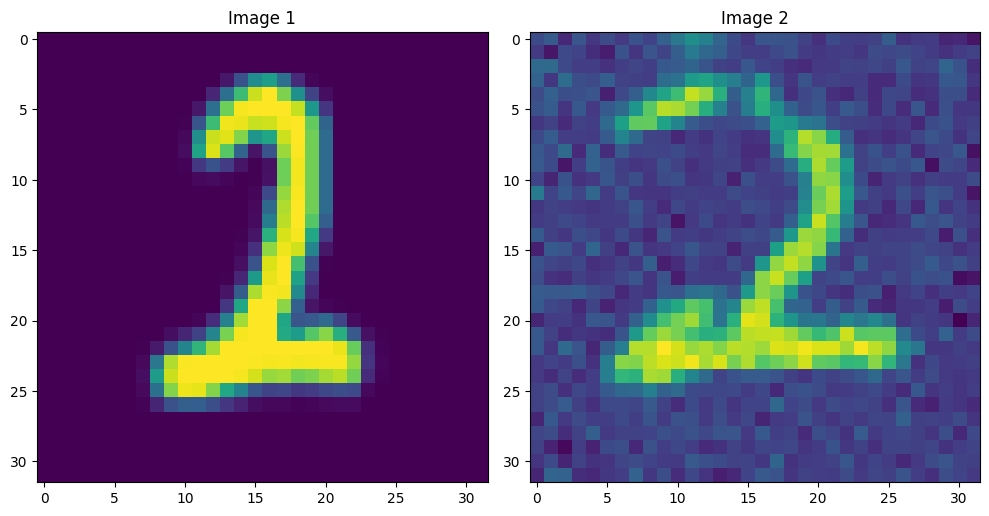

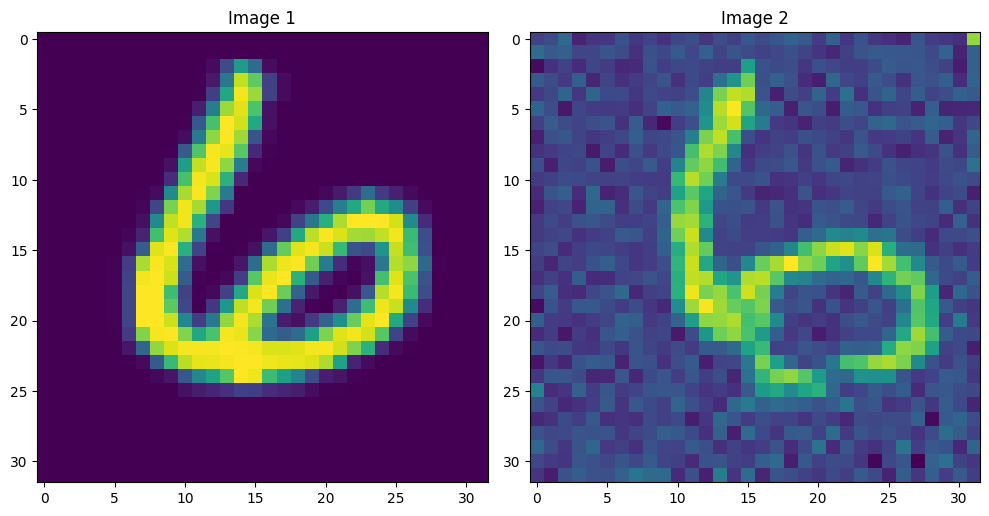

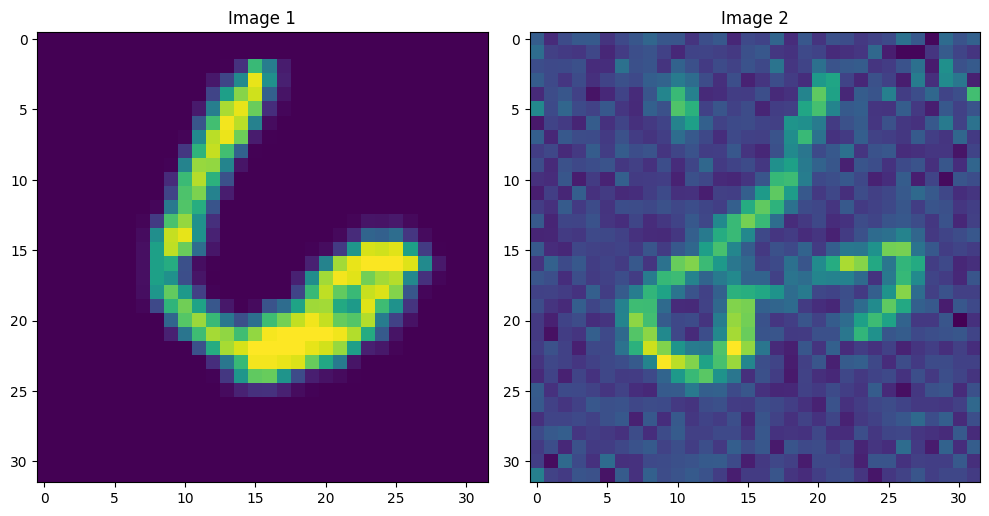

In [72]:
print_result(result_DDIM)

# Evaluation

In [73]:
from transformers import pipeline

pipe = pipeline("image-classification",
                model="farleyknight-org-username/vit-base-mnist",
                device=device)

def inception_ViT(inputs):

    def convert_to_pil(x):
        res = []
        for i in range(x.shape[0]):
            res.append(to_pil_image(x[i]))
        return res

    def help(result):
        res = [0.00000001] * 10
        for r in result:
            res[int(r['label'])] = r['score']
        return res

    # inputs : [B, 1, 32, 32]
    out = pipe(convert_to_pil(inputs))
    out = [help(x) for x in out]
    return out

In [82]:
# Function to get inception features
def get_inception_features(inception_model, result):
    target, origin = [], []

    for image, noised_image, denoised_image in result:
        # denoised_image : [B, 1, 32, 32]
        origin += inception_model(image)
        target += inception_model(denoised_image)

    return origin, target

# Calculate FID
def calculate_fid(origin, target):
    mu1, sigma1 = np.mean(origin, axis=0), np.cov(origin, rowvar=False)
    mu2, sigma2 = np.mean(target, axis=0), np.cov(target, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def calculate_inception_score(results):
    scores = []
    for part in results:
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([np.sum(p * np.log(p / py)) for p in part])))
    return np.mean(scores), np.std(scores)

In [83]:
origin_DDPM, target_DDPM = get_inception_features(inception_ViT, result_DDPM)

inception_score_mean, inception_score_std = calculate_inception_score(origin_DDPM)
print(f'[Origin] IS: {inception_score_mean} ± {inception_score_std}')

inception_score_mean, inception_score_std = calculate_inception_score(target_DDPM)
print(f'[Target] IS: {inception_score_mean} ± {inception_score_std}')

fid = calculate_fid(origin_DDPM, target_DDPM)
print(f'FID: {fid}')

[Origin] IS: 1.2552816567892608 ± 0.0030089533020597283
[Target] IS: 1.068866670015037 ± 0.025740457551422197
FID: 0.6987992018315238


In [84]:
origin_DDIM, target_DDIM = get_inception_features(inception_ViT, result_DDIM)

inception_score_mean, inception_score_std = calculate_inception_score(origin_DDIM)
print(f'[Origin] IS: {inception_score_mean} ± {inception_score_std}')

inception_score_mean, inception_score_std = calculate_inception_score(target_DDIM)
print(f'[Target] IS: {inception_score_mean} ± {inception_score_std}')

fid = calculate_fid(origin_DDIM, target_DDIM)
print(f'FID: {fid}')

[Origin] IS: 1.2552816567892608 ± 0.0030089533020597283
[Target] IS: 1.068866670015037 ± 0.025740457551422197
FID: 0.6987992018315238
